# 1. Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load datasets
weather = pd.read_csv("boston-weather-data(open_meteo) (1).csv", skiprows=3)
print(weather.columns.tolist())
pollution = pd.read_csv("boston_pollutants_with_aqi.csv")
pollen = pd.read_csv("EPHT_Pollen_Data.csv")

# parse date columns
weather['time'] = pd.to_datetime(weather['time'])
pollution['date'] = pd.to_datetime(pollution['date'])
pollen['Date'] = pd.to_datetime(pollen['Date'])

# rename and merge
weather.rename(columns={'time': 'Date'}, inplace=True)
pollution.rename(columns={'date': 'Date'}, inplace=True)

merged = (
    weather
    .merge(pollution, on='Date', how='inner')
    .merge(pollen, on='Date', how='inner')
)

merged.info()

# filter for pollen season (March through October)
merged = merged[merged['Date'].dt.month.isin(range(3, 11))]


# select relevant numeric columns
cols = [
    # Weather (all numeric)
    'weather_code (wmo code)',
    'temperature_2m_mean (°C)',
    'apparent_temperature_mean (°C)',
    'precipitation_sum (mm)',
    'wind_gusts_10m_max (km/h)',
    'wind_speed_10m_max (km/h)',
    'wind_direction_10m_dominant (°)',

    # Pollution
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2',
    'AQI', 'num_pollutants_available',

    # Pollen
    'Tree', 'Grass', 'Weed', 'Ragweed', 'Total_Pollen'
]

numeric = merged[[c for c in cols if c in merged.columns]]
corr = numeric.corr()



['time', 'temperature_2m_mean (°C)', 'precipitation_sum (mm)', 'apparent_temperature_mean (°C)', 'wind_gusts_10m_max (km/h)', 'wind_speed_10m_max (km/h)', 'wind_direction_10m_dominant (°)']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2066 entries, 0 to 2065
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             2066 non-null   datetime64[ns]
 1   temperature_2m_mean (°C)         2066 non-null   float64       
 2   precipitation_sum (mm)           2066 non-null   float64       
 3   apparent_temperature_mean (°C)   2066 non-null   float64       
 4   wind_gusts_10m_max (km/h)        2066 non-null   float64       
 5   wind_speed_10m_max (km/h)        2066 non-null   float64       
 6   wind_direction_10m_dominant (°)  2066 non-null   int64         
 7   PM2.5                            2057 non-null   float64       
 8   O3      

# 2. Linear Regression Model - Not Very Good


MAE: 89.0091943339086
RMSE: 176.08537156205279
R²: 0.1230744813575092
                            feature  coefficient
12                           AQI_O3   231.282516
14                          AQI_NO2   205.743983
7                                O3  -178.997588
9                               NO2  -172.943937
1    apparent_temperature_mean (°C)  -171.120067
0          temperature_2m_mean (°C)   141.824499
6                             PM2.5   -47.742608
15                          AQI_SO2   -41.828785
11                        AQI_PM2.5    23.835272
16                              AQI    23.519343
3         wind_gusts_10m_max (km/h)   -18.525209
5   wind_direction_10m_dominant (°)   -15.140248
8                                CO   -10.531590
10                              SO2     8.325233
13                           AQI_CO    -5.494664
4         wind_speed_10m_max (km/h)     5.014623
2            precipitation_sum (mm)    -1.085136
17         num_pollutants_available     0.000000

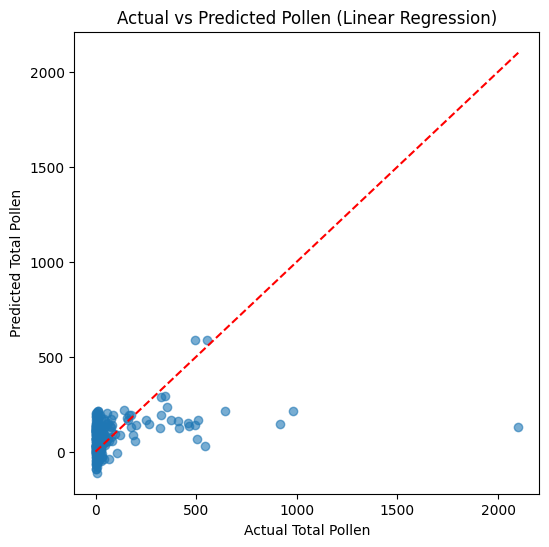

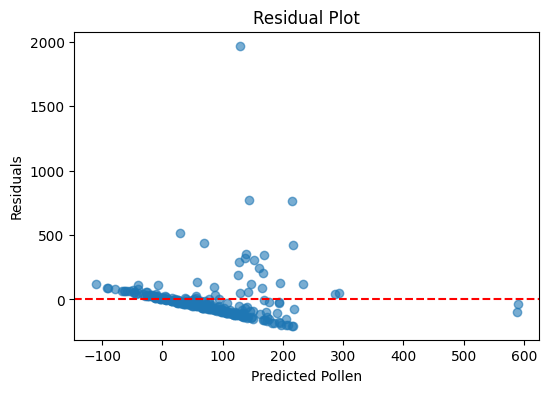

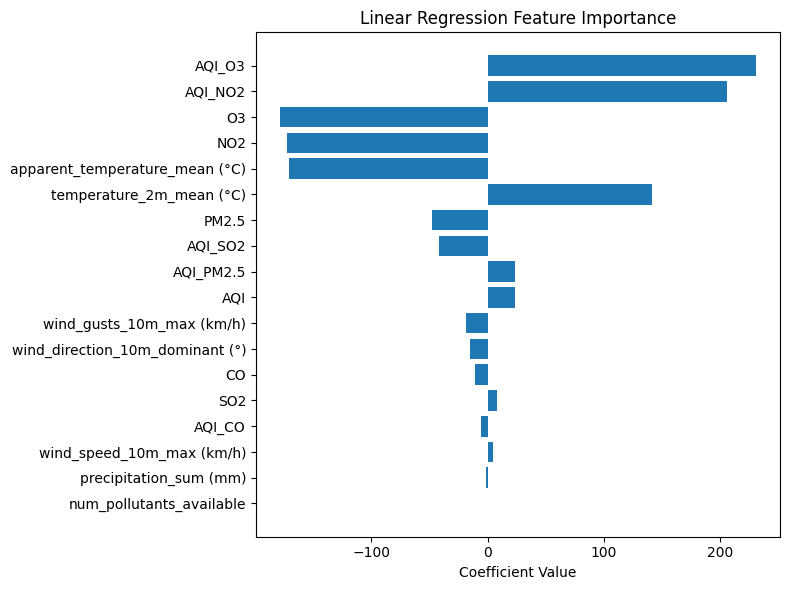

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# use the merged dataframe
df = merged.copy()

# drop rows with missing values in predictors or target
df = df.dropna(subset=numeric.columns)

# ------------------------------
# 1. Select target + features
# ------------------------------
target = "Total_Pollen"   
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"] # remove pollen related variables 
features = [c for c in numeric.columns if c not in remove_cols]

X = df[features]
y = df[target]

# ------------------------------
# 2. Split data
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------
# 3. Scale features
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 4. Train linear regression
# ------------------------------
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# ------------------------------
# 5. Model evaluation
# ------------------------------
y_pred = model.predict(X_test_scaled)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# ------------------------------
# 6. Coefficients (feature importance for linear regression)
# ------------------------------
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_
}).sort_values(by="coefficient", key=abs, ascending=False)

print(coef_df)

# ------------------------------
# 7. Visualize it
# ------------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Total Pollen")
plt.ylabel("Predicted Total Pollen")
plt.title("Actual vs Predicted Pollen (Linear Regression)")
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


plt.figure(figsize=(8,6))
coef_df_sorted = coef_df.sort_values("coefficient", key=abs)

plt.barh(coef_df_sorted["feature"], coef_df_sorted["coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Linear Regression Feature Importance")
plt.tight_layout()
plt.show()

# With 2023 Data

2009-07-20 00:00:00 2023-10-12 00:00:00
[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023]
(0, 34)
MAE: 109.44812341634893
RMSE: 245.88884094355652
R²: 0.10491537584179567
                            feature  coefficient
12                           AQI_O3   212.197799
7                                O3  -155.067778
14                          AQI_NO2   131.520911
9                               NO2  -108.336346
1    apparent_temperature_mean (°C)   -93.794426
6                             PM2.5   -71.386970
0          temperature_2m_mean (°C)    63.328000
15                          AQI_SO2   -43.513596
11                        AQI_PM2.5    38.713593
16                              AQI    28.315735
10                              SO2    17.172090
5   wind_direction_10m_dominant (°)   -16.262747
13                           AQI_CO   -13.448993
3         wind_gusts_10m_max (km/h)   -10.395382
2            precipitation_sum (mm)    -3.264740
8                

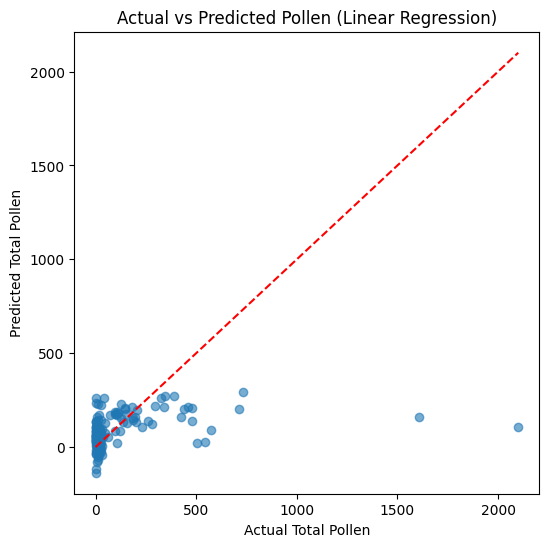

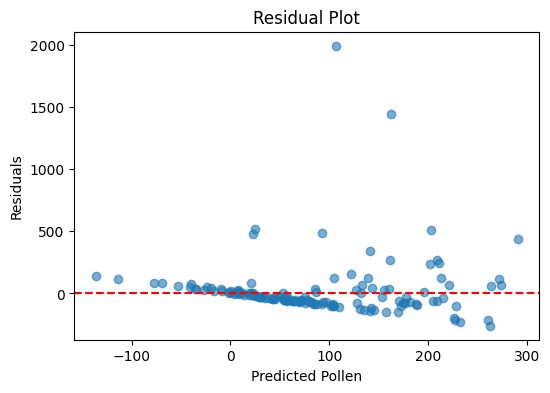

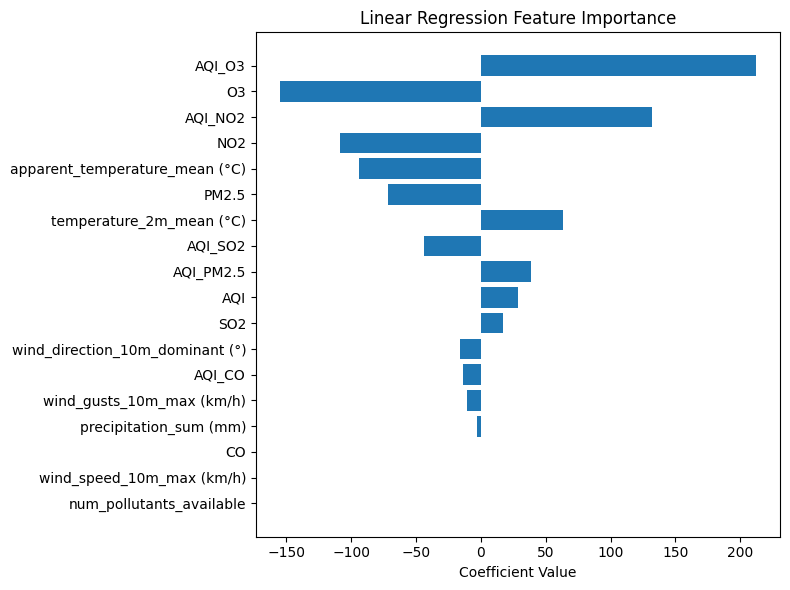

In [47]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# use the merged dataframe
df = merged.copy()

# drop rows with missing values in predictors or target
df = df.dropna(subset=numeric.columns)

# ------------------------------
# 1. Select target + features
# ------------------------------
target = "Total_Pollen"   
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"] # remove pollen related variables 
features = [c for c in numeric.columns if c not in remove_cols]

# ------------------------------
# 2. Split data by date (all 2024 as test)
# ------------------------------
df = df.sort_values("Date")  # make sure dates are in order

train_df = df[df['Year'] < 2023]   # all years before 2024 for training
test_df = df[df['Year'] == 2023]   # all of 2024 for testing

print(df['Date'].min(), df['Date'].max())       # check the full date range
print(df['Date'].dt.year.unique())             # see which years exist
print(df[df['Date'].dt.year == 2024].shape)    # see how many rows for 2024

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

# ------------------------------
# 3. Scale features
# ------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ------------------------------
# 4. Train linear regression
# ------------------------------
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# ------------------------------
# 5. Model evaluation
# ------------------------------
y_pred = model.predict(X_test_scaled)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# ------------------------------
# 6. Coefficients (feature importance for linear regression)
# ------------------------------
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_
}).sort_values(by="coefficient", key=abs, ascending=False)

print(coef_df)

# ------------------------------
# 7. Visualize results
# ------------------------------

# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Total Pollen")
plt.ylabel("Predicted Total Pollen")
plt.title("Actual vs Predicted Pollen (Linear Regression)")
plt.show()

# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# Feature importance (coefficients)
plt.figure(figsize=(8,6))
coef_df_sorted = coef_df.sort_values("coefficient", key=abs)
plt.barh(coef_df_sorted["feature"], coef_df_sorted["coefficient"])
plt.xlabel("Coefficient Value")
plt.title("Linear Regression Feature Importance")
plt.tight_layout()
plt.show()


# 3. Random Forest

Training Metrics:
MAE: 19.594913547020017
RMSE: 79.09998321061754
R²: 0.9048637896565802

Test Metrics:
MAE: 19.827513685548645
RMSE: 51.99203451441386
R²: 0.8967909754371937
                     feature  importance
21               pollen_3day    0.827944
23                  is_spike    0.073938
19                      lag2    0.018244
18                      lag1    0.014251
2     precipitation_sum (mm)    0.002986
..                       ...         ...
13                    AQI_CO    0.000041
74              AQI_SO2_lag3    0.000038
73              AQI_SO2_lag2    0.000022
72              AQI_SO2_lag1    0.000014
17  num_pollutants_available    0.000000

[81 rows x 2 columns]


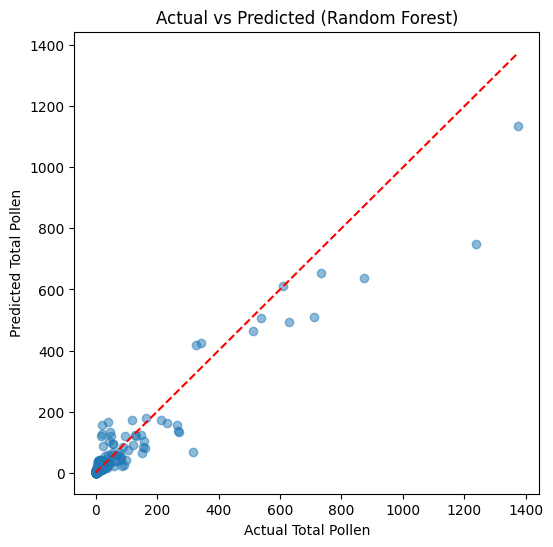

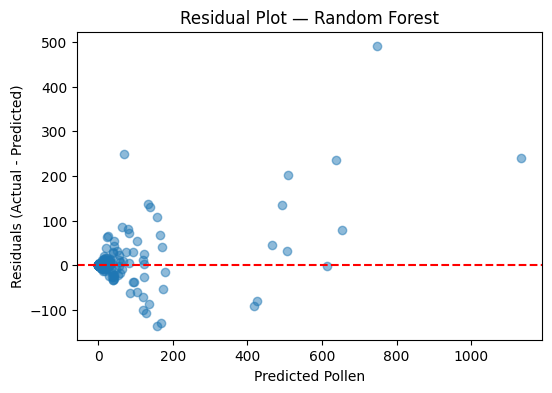

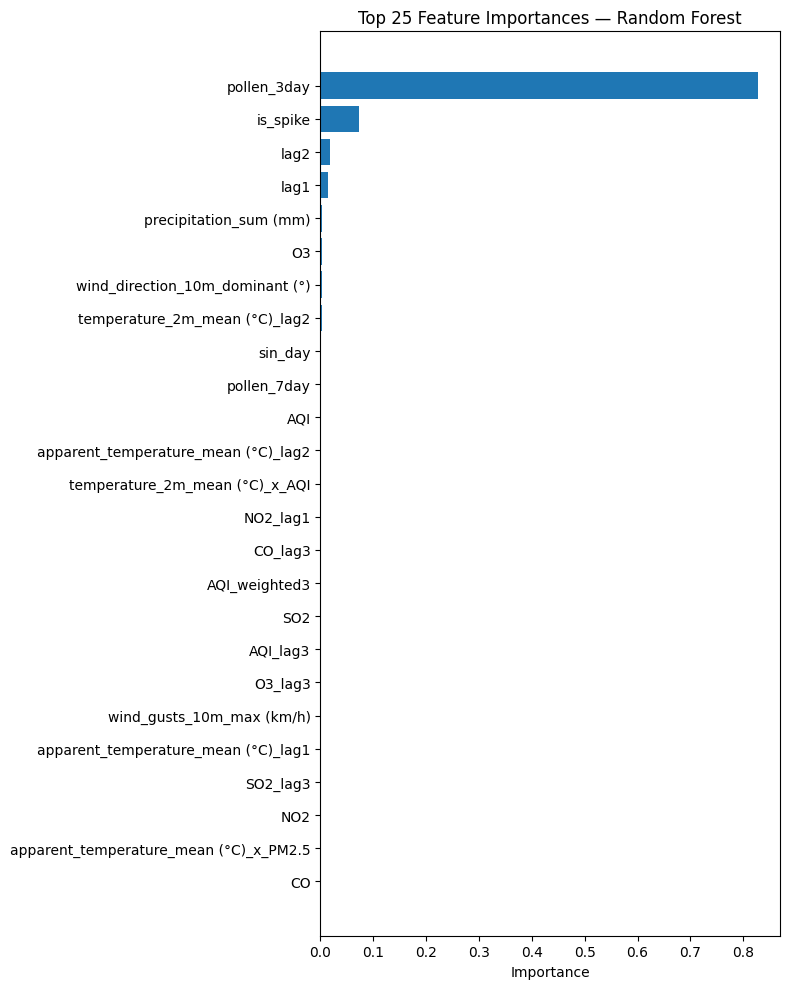

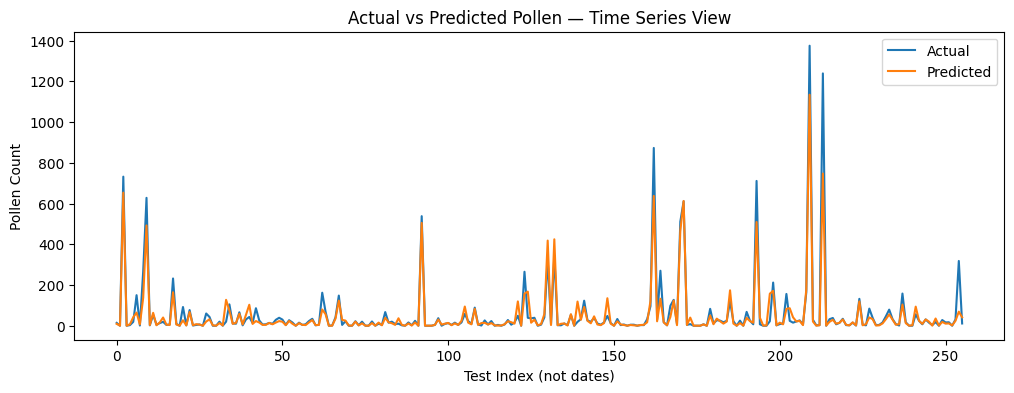

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- copy dataframe ---
df = merged.copy()

# --- drop rows w/ NA in numeric columns ---
df = df.dropna(subset=numeric.columns)

# ==============================================================
# 1. BASIC ENGINEERED FEATURES (your original)
# ==============================================================

df["day_of_year"] = df["Date"].dt.dayofyear
df["lag1"] = df["Total_Pollen"].shift(1)
df["lag2"] = df["Total_Pollen"].shift(2)
df["lag3"] = df["Total_Pollen"].shift(3)
df["pollen_3day"] = df["Total_Pollen"].rolling(3).mean()
df["pollen_7day"] = df["Total_Pollen"].rolling(7).mean()

# spike indicator: 1 if pollen > mean + 1 std
threshold = df["Total_Pollen"].mean() + df["Total_Pollen"].std()
df["is_spike"] = (df["Total_Pollen"] > threshold).astype(int)

# drop NA from new features
df = df.dropna(subset=["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"])

# ==============================================================
# 2. ORIGINAL FEATURE LISTS
# ==============================================================

target = "Total_Pollen"
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"]

base_features = [c for c in numeric.columns if c not in remove_cols]
extra_features = ["day_of_year", "lag1", "lag2", "lag3", "pollen_3day", "pollen_7day", "is_spike"]

features = base_features + extra_features

X = df[features]
y = df[target]

# ==============================================================
# 3. ADVANCED FEATURES FROM SUCCESSFUL SCRIPT
# ==============================================================

# --- Seasonal sin/cos ---
X = df[features].copy()

# --- Seasonal sin/cos ---
X["sin_day"] = np.sin(2 * np.pi * X["day_of_year"] / 365)
X["cos_day"] = np.cos(2 * np.pi * X["day_of_year"] / 365)
X = X.drop(columns=["day_of_year"])

# --- Weighted rolling averages (3-day) ---
weights = np.array([0.1, 0.3, 0.6])  # older → newer emphasis

rolling_cols = [
    "temperature_2m_mean (°C)", "apparent_temperature_mean (°C)",
    "PM2.5", "O3", "CO", "NO2", "SO2",
    "AQI_PM2.5", "AQI_O3", "AQI_CO", "AQI_NO2", "AQI_SO2", "AQI"
]

for col in rolling_cols:
    X[f"{col}_weighted3"] = (
        X[col].shift(2).bfill() * weights[0] +
        X[col].shift(1).bfill() * weights[1] +
        X[col] * weights[2]
    )

# --- Lag features (t-1, t-2, t-3) for pollutants/meteo ---
for col in rolling_cols:
    for lag in range(1, 4):
        X[f"{col}_lag{lag}"] = X[col].shift(lag).bfill()

# --- Interaction features ---
interaction_pairs = [
    ("temperature_2m_mean (°C)", "AQI"),
    ("apparent_temperature_mean (°C)", "PM2.5"),
    ("wind_speed_10m_max (km/h)", "O3"),
]

for col1, col2 in interaction_pairs:
    X[f"{col1}_x_{col2}"] = X[col1] * X[col2]

# ==============================================================
# 4. LOG-TRANSFORM TARGET
# ==============================================================

y_log = np.log1p(y)

# ==============================================================
# 5. TRAIN/TEST SPLIT
# ==============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# ==============================================================
# 6. RANDOM FOREST MODEL
# ==============================================================

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features=None,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# --- prediction ---
y_pred_log = rf.predict(X_test)
y_pred = np.expm1(y_pred_log)

# ==============================================================
# 7. METRICS
# ==============================================================

# --- Predictions ---
y_train_pred_log = rf.predict(X_train)
y_test_pred_log  = rf.predict(X_test)

# inverse log-transform
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred  = np.expm1(y_test_pred_log)

y_train_real = np.expm1(y_train)
y_test_real  = np.expm1(y_test)

print("Training Metrics:")
print("MAE:", mean_absolute_error(y_train_real, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train_real, y_train_pred)))
print("R²:", r2_score(y_train_real, y_train_pred))

print("\nTest Metrics:")
print("MAE:", mean_absolute_error(y_test_real, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_test_pred)))
print("R²:", r2_score(y_test_real, y_test_pred))

# ==============================================================
# 8. FEATURE IMPORTANCE
# ==============================================================

importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

print(importances)


# ==============================================================
# 8. VISUALIZATIONS
# ==============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test_real, y_test_pred, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()],
         'r--')
plt.xlabel("Actual Total Pollen")
plt.ylabel("Predicted Total Pollen")
plt.title("Actual vs Predicted (Random Forest)")
plt.show()


residuals = y_test_real - y_test_pred

plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot — Random Forest")
plt.show()

top_k = 25
top_feats = importances.head(top_k).sort_values("importance")

plt.figure(figsize=(8,10))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_k} Feature Importances — Random Forest")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test_real.values, label="Actual")
plt.plot(y_test_pred, label="Predicted")
plt.title("Actual vs Predicted Pollen — Time Series View")
plt.xlabel("Test Index (not dates)")
plt.ylabel("Pollen Count")
plt.legend()
plt.show()

# With 2023 Data

Train size: (1910, 81)
Test size: (150, 81)
Training Metrics:
MAE: 19.484509435353857
RMSE: 66.1559427237461
R²: 0.9407610176356337

Test Metrics:
MAE: 39.35474205003956
RMSE: 120.19145300848471
R²: 0.773475842339878
                     feature  importance
21               pollen_3day    0.773459
23                  is_spike    0.111107
19                      lag2    0.029481
18                      lag1    0.023440
2     precipitation_sum (mm)    0.005607
..                       ...         ...
63               AQI_CO_lag1    0.000056
15                   AQI_SO2    0.000045
71              AQI_SO2_lag1    0.000033
72              AQI_SO2_lag2    0.000030
17  num_pollutants_available    0.000019

[81 rows x 2 columns]


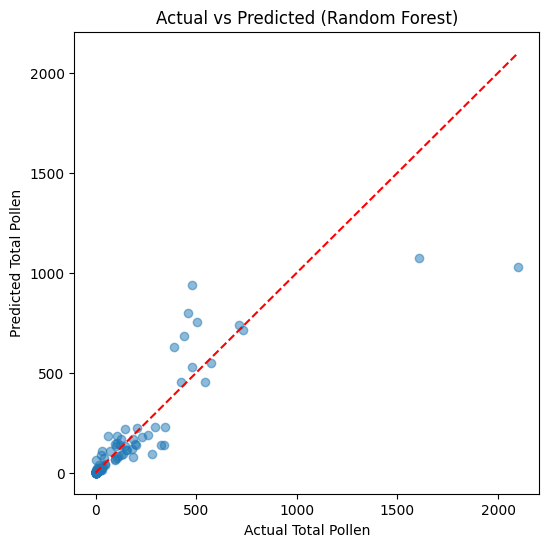

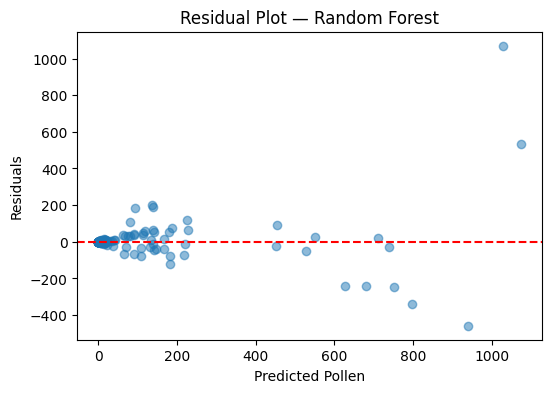

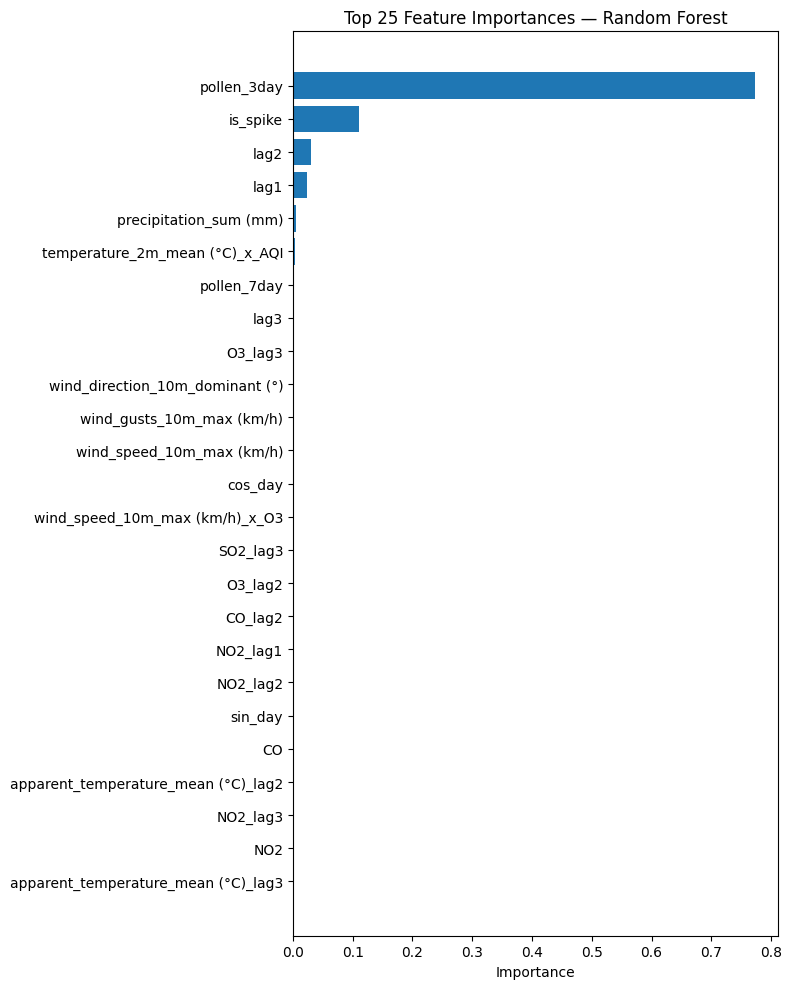

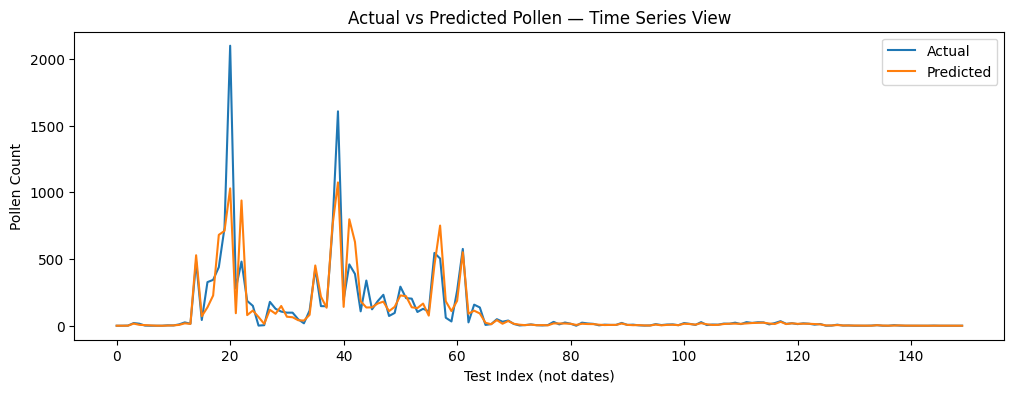

In [49]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --- copy dataframe ---
df = merged.copy()

# --- ensure all numeric columns are numeric (convert 'Not Collected', 'Absent', etc. to NaN) ---
for col in numeric.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- fill missing numeric values (can also use median instead of 0 if preferred) ---
df[numeric.columns] = df[numeric.columns].fillna(0)

# ==============================================================
# 1. BASIC ENGINEERED FEATURES
# ==============================================================
df["day_of_year"] = df["Date"].dt.dayofyear
df["lag1"] = df["Total_Pollen"].shift(1)
df["lag2"] = df["Total_Pollen"].shift(2)
df["lag3"] = df["Total_Pollen"].shift(3)
df["pollen_3day"] = df["Total_Pollen"].rolling(3).mean()
df["pollen_7day"] = df["Total_Pollen"].rolling(7).mean()

threshold = df["Total_Pollen"].mean() + df["Total_Pollen"].std()
df["is_spike"] = (df["Total_Pollen"] > threshold).astype(int)

df = df.dropna(subset=["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"])

# ==============================================================
# 2. FEATURE LISTS
# ==============================================================
target = "Total_Pollen"
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"]

base_features = [c for c in numeric.columns if c not in remove_cols]
extra_features = ["day_of_year", "lag1", "lag2", "lag3", "pollen_3day", "pollen_7day", "is_spike"]
features = base_features + extra_features

X = df[features]
y = df[target]

# ==============================================================
# 3. ADVANCED FEATURES
# ==============================================================
X = X.copy()
X["sin_day"] = np.sin(2 * np.pi * X["day_of_year"] / 365)
X["cos_day"] = np.cos(2 * np.pi * X["day_of_year"] / 365)
X = X.drop(columns=["day_of_year"])

weights = np.array([0.1, 0.3, 0.6])
rolling_cols = [
    "temperature_2m_mean (°C)", "apparent_temperature_mean (°C)",
    "PM2.5", "O3", "CO", "NO2", "SO2",
    "AQI_PM2.5", "AQI_O3", "AQI_CO", "AQI_NO2", "AQI_SO2", "AQI"
]

for col in rolling_cols:
    X[f"{col}_weighted3"] = (
        X[col].shift(2).bfill() * weights[0] +
        X[col].shift(1).bfill() * weights[1] +
        X[col] * weights[2]
    )
    for lag in range(1, 4):
        X[f"{col}_lag{lag}"] = X[col].shift(lag).bfill()

interaction_pairs = [
    ("temperature_2m_mean (°C)", "AQI"),
    ("apparent_temperature_mean (°C)", "PM2.5"),
    ("wind_speed_10m_max (km/h)", "O3"),
]

for col1, col2 in interaction_pairs:
    X[f"{col1}_x_{col2}"] = X[col1] * X[col2]

# ==============================================================
# 4. LOG-TRANSFORM TARGET
# ==============================================================
y_log = np.log1p(y)

# ==============================================================
# 5. TRAIN/TEST SPLIT USING YEAR
# ==============================================================
# ensure 'Year' exists
df['Year'] = df['Date'].dt.year

train_df = df[df['Year'] < 2023]
test_df = df[df['Year'] == 2023]

X_train = X.loc[train_df.index]
y_train = y_log.loc[train_df.index]

X_test = X.loc[test_df.index]
y_test = y_log.loc[test_df.index]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# ==============================================================
# 6. RANDOM FOREST MODEL
# ==============================================================
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=4,
    max_features=None,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# --- predictions ---
y_train_pred_log = rf.predict(X_train)
y_test_pred_log = rf.predict(X_test)

y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

y_train_real = np.expm1(y_train)
y_test_real = np.expm1(y_test)

# ==============================================================
# 7. METRICS
# ==============================================================
print("Training Metrics:")
print("MAE:", mean_absolute_error(y_train_real, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train_real, y_train_pred)))
print("R²:", r2_score(y_train_real, y_train_pred))

print("\nTest Metrics:")
print("MAE:", mean_absolute_error(y_test_real, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test_real, y_test_pred)))
print("R²:", r2_score(y_test_real, y_test_pred))

# ==============================================================
# 8. FEATURE IMPORTANCE
# ==============================================================
importances = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)
print(importances)

# ==============================================================
# 9. VISUALIZATIONS
# ==============================================================
plt.figure(figsize=(6,6))
plt.scatter(y_test_real, y_test_pred, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel("Actual Total Pollen")
plt.ylabel("Predicted Total Pollen")
plt.title("Actual vs Predicted (Random Forest)")
plt.show()

residuals = y_test_real - y_test_pred
plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residuals")
plt.title("Residual Plot — Random Forest")
plt.show()

top_k = 25
top_feats = importances.head(top_k).sort_values("importance")
plt.figure(figsize=(8,10))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_k} Feature Importances — Random Forest")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test_real.values, label="Actual")
plt.plot(y_test_pred, label="Predicted")
plt.title("Actual vs Predicted Pollen — Time Series View")
plt.xlabel("Test Index (not dates)")
plt.ylabel("Pollen Count")
plt.legend()
plt.show()


# 4. LightGBM


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3572
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 88.673611
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 56.9294	valid_0's l2: 3240.95
[100]	valid_0's rmse: 54.4161	valid_0's l2: 2961.11
[150]	valid_0's rmse: 50.533	valid_0's l2: 2553.58
[200]	valid_0's rmse: 48.547	valid_0's l2: 2356.81
[250]	valid_0's rmse: 47.6874	valid_0's l2: 2274.08
[300]	valid_0's rmse: 45.9382	valid_0's l2: 2110.32
[350]	valid_0's rmse: 44.6775	valid_0's l2: 1996.08
[400]	valid_0's rmse: 44.2033	valid_0's l2: 1953.93
[450]	valid_0's rmse: 44

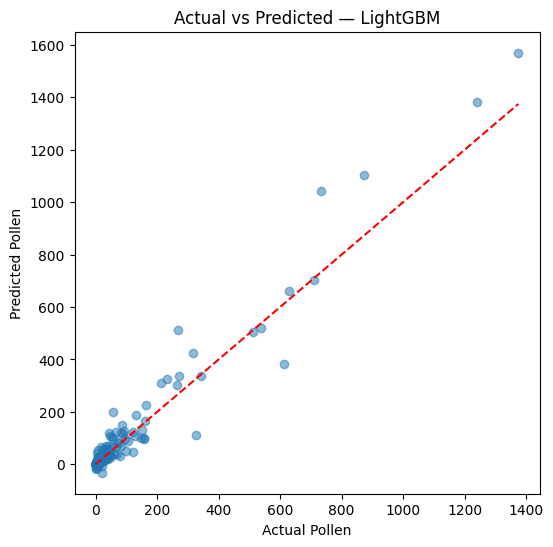

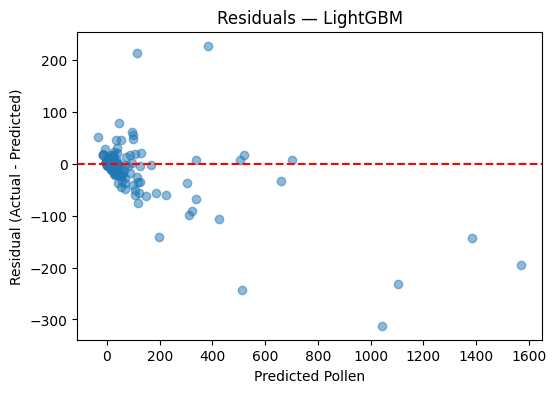

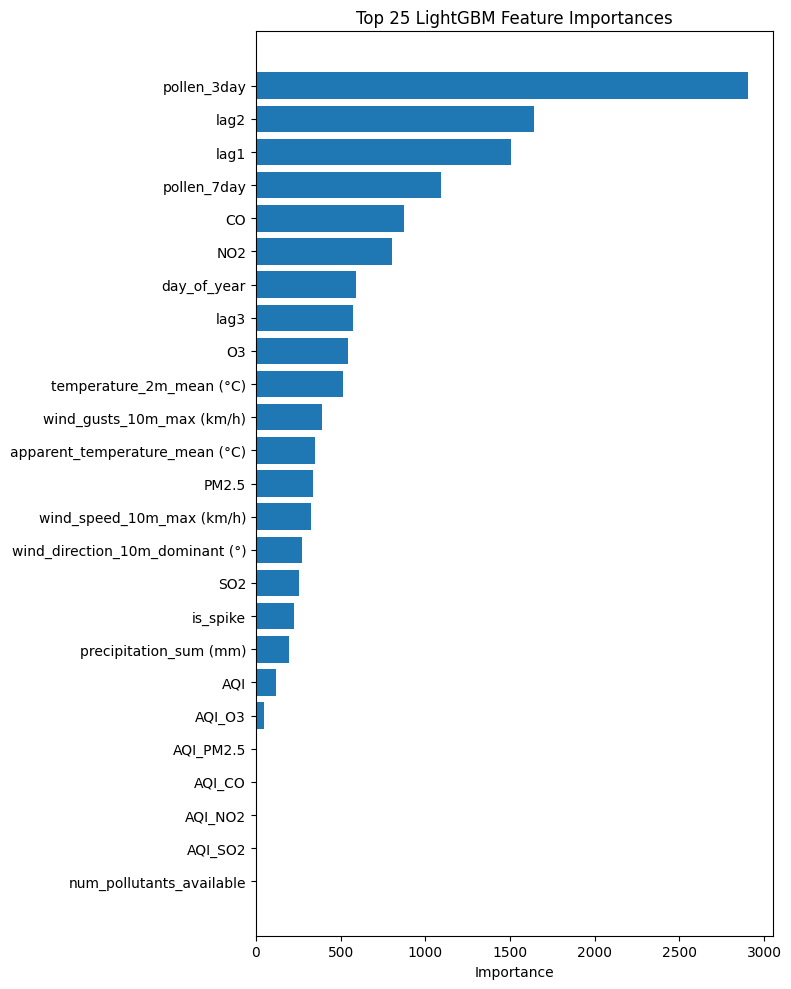

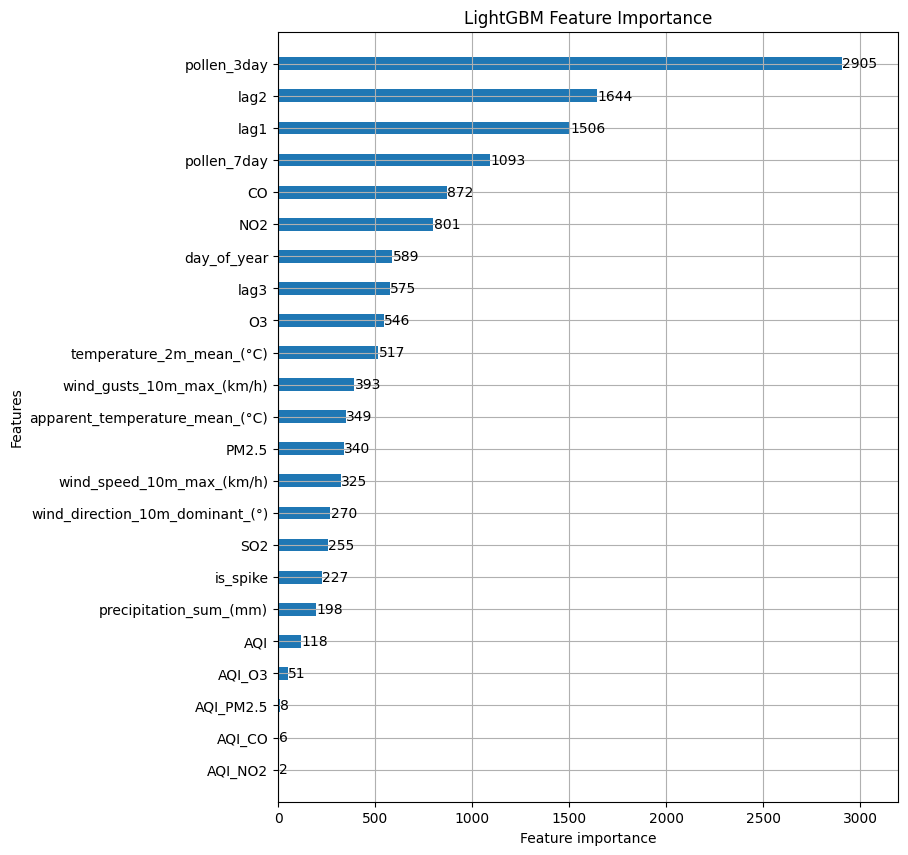

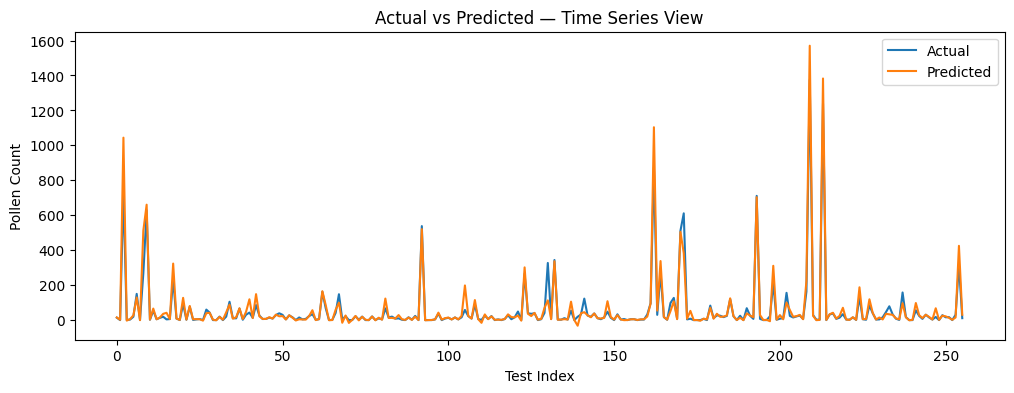

In [45]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb

# --------------------------
# 1. Prepare dataframe
# --------------------------
df = merged.copy()

# Drop rows with missing numeric features
df = df.dropna(subset=numeric.columns)

# Create lag and rolling features
df["day_of_year"] = df["Date"].dt.dayofyear
df["lag1"] = df["Total_Pollen"].shift(1)
df["lag2"] = df["Total_Pollen"].shift(2)
df["lag3"] = df["Total_Pollen"].shift(3)
df["pollen_3day"] = df["Total_Pollen"].rolling(3).mean()
df["pollen_7day"] = df["Total_Pollen"].rolling(7).mean()

# Create spike feature (example: > 75th percentile of recent 3-day mean)
df["is_spike"] = ((df["Total_Pollen"] - df["pollen_3day"]) > df["pollen_3day"].quantile(0.75)).astype(int)

df = df.dropna(subset=["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"])

# --------------------------
# 2. Define target & features
# --------------------------
target = "Total_Pollen"
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"]

base_features = [c for c in numeric.columns if c not in remove_cols]
extra_features = ["day_of_year", "lag1", "lag2", "lag3", "pollen_3day", "pollen_7day", "is_spike"]
features = base_features + extra_features

X = df[features]
y = df[target]

# --------------------------
# 3. Train/test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# 4. LightGBM model
# --------------------------
lgb_reg = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

# Fit with early stopping
lgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)

# --------------------------
# 5. Predictions
# --------------------------
y_pred = lgb_reg.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# --------------------------
# 6. Feature importance
# --------------------------
importances = pd.DataFrame({
    "feature": features,
    "importance": lgb_reg.feature_importances_
}).sort_values(by="importance", ascending=False)

print(importances)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Pollen")
plt.ylabel("Predicted Pollen")
plt.title("Actual vs Predicted — LightGBM")
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals — LightGBM")
plt.show()

top_k = 25
top_feats = importances.head(top_k).sort_values("importance")

plt.figure(figsize=(8,10))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_k} LightGBM Feature Importances")
plt.tight_layout()
plt.show()


lgb.plot_importance(lgb_reg, max_num_features=25, height=0.4, figsize=(8, 10))
plt.title("LightGBM Feature Importance")
plt.show()


plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted — Time Series View")
plt.xlabel("Test Index")
plt.ylabel("Pollen Count")
plt.legend()
plt.show()


# With 2023 Data

Train size: (1910, 25)
Test size: (150, 25)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4258
[LightGBM] [Info] Number of data points in the train set: 1910, number of used features: 25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 109.770068
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 80.7802	valid_0's l2: 6525.44
[100]	valid_0's rmse: 77.2725	valid_0's l2: 5971.05
Early stopping, best iteration is:
[99]	valid_0's rmse: 77.2557	valid_0's l2: 5968.44
MAE: 30.42098441526404
RMSE: 77.25570134667844
R²: 0.9064102187304376
                            feature  importance
22                   

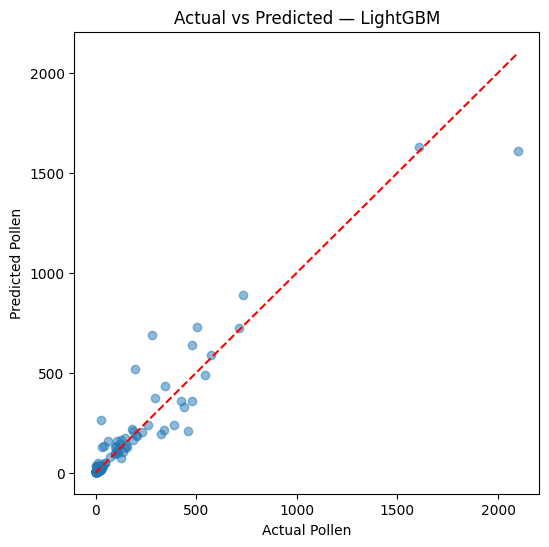

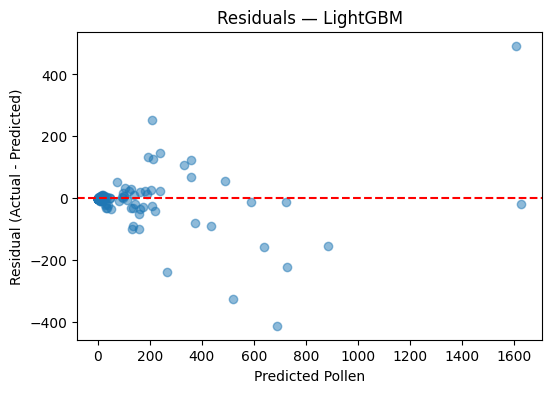

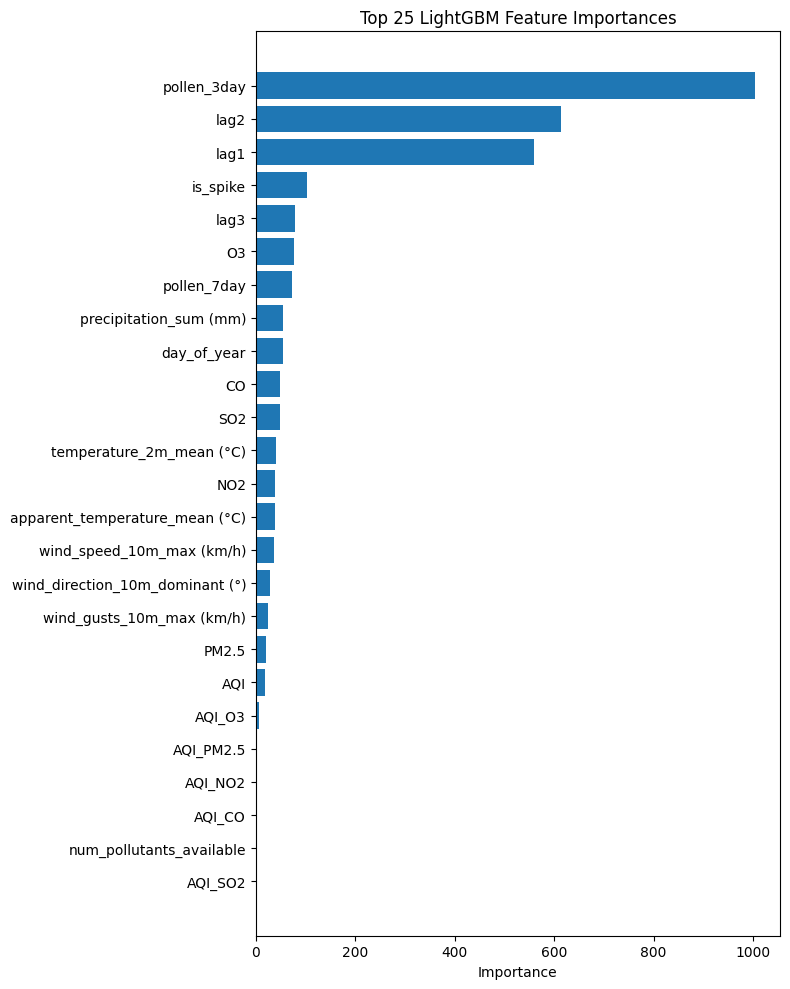

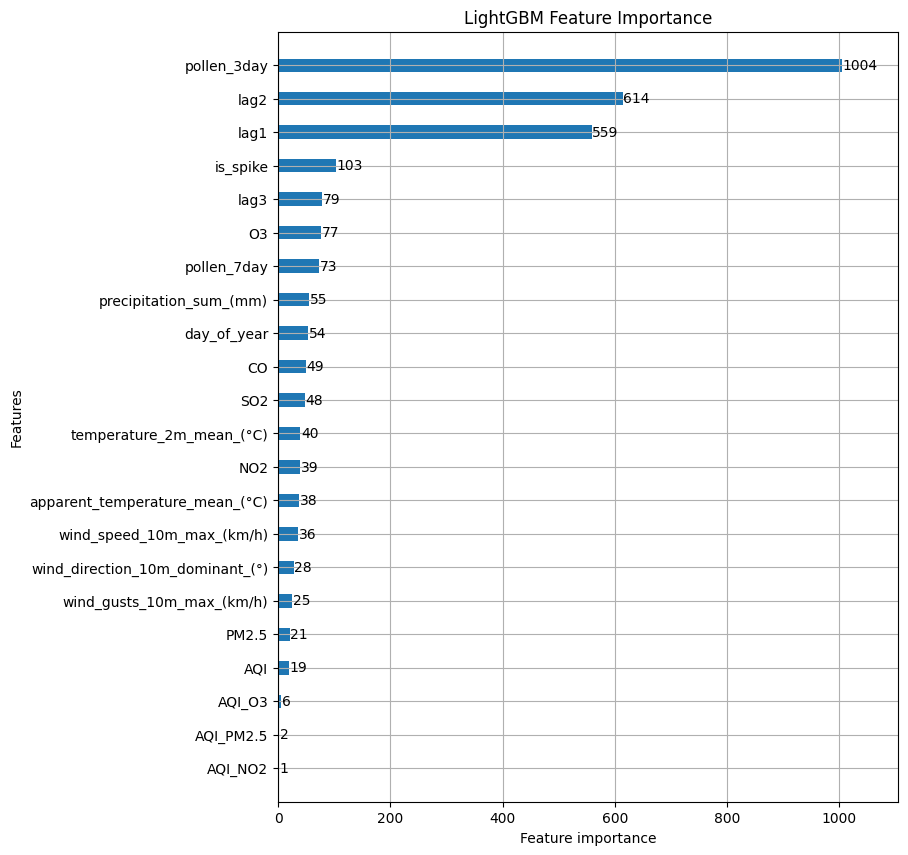

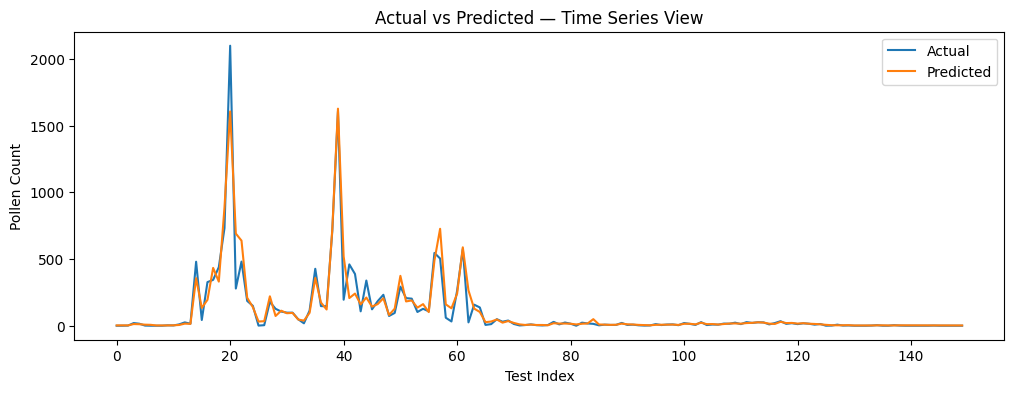

In [51]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --------------------------
# 1. Prepare dataframe
# --------------------------
df = merged.copy()

# Ensure numeric columns are truly numeric
for col in numeric.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill missing numeric values
df[numeric.columns] = df[numeric.columns].fillna(0)

# Create lag and rolling features
df["day_of_year"] = df["Date"].dt.dayofyear
df["lag1"] = df["Total_Pollen"].shift(1)
df["lag2"] = df["Total_Pollen"].shift(2)
df["lag3"] = df["Total_Pollen"].shift(3)
df["pollen_3day"] = df["Total_Pollen"].rolling(3).mean()
df["pollen_7day"] = df["Total_Pollen"].rolling(7).mean()

# Spike feature
df["is_spike"] = ((df["Total_Pollen"] - df["pollen_3day"]) > df["pollen_3day"].quantile(0.75)).astype(int)

# Drop rows with NaNs in rolling/lag features
df = df.dropna(subset=["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"])

# --------------------------
# 2. Define target & features
# --------------------------
target = "Total_Pollen"
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"]

base_features = [c for c in numeric.columns if c not in remove_cols]
extra_features = ["day_of_year", "lag1", "lag2", "lag3", "pollen_3day", "pollen_7day", "is_spike"]
features = base_features + extra_features

X = df[features].copy()
y = df[target]

# --------------------------
# 3. Train/test split by year (2024 test)
# --------------------------
df['Year'] = df['Date'].dt.year

train_df = df[df['Year'] < 2023]
test_df = df[df['Year'] == 2023]

X_train = X.loc[train_df.index]
y_train = y.loc[train_df.index]

X_test = X.loc[test_df.index]
y_test = y.loc[test_df.index]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# --------------------------
# 4. LightGBM model
# --------------------------
lgb_reg = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)

lgb_reg.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)]
)

# --------------------------
# 5. Predictions
# --------------------------
y_pred = lgb_reg.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# --------------------------
# 6. Feature importance
# --------------------------
importances = pd.DataFrame({
    "feature": features,
    "importance": lgb_reg.feature_importances_
}).sort_values(by="importance", ascending=False)

print(importances)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Pollen")
plt.ylabel("Predicted Pollen")
plt.title("Actual vs Predicted — LightGBM")
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals — LightGBM")
plt.show()

top_k = 25
top_feats = importances.head(top_k).sort_values("importance")
plt.figure(figsize=(8,10))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.xlabel("Importance")
plt.title(f"Top {top_k} LightGBM Feature Importances")
plt.tight_layout()
plt.show()

lgb.plot_importance(lgb_reg, max_num_features=25, height=0.4, figsize=(8, 10))
plt.title("LightGBM Feature Importance")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted — Time Series View")
plt.xlabel("Test Index")
plt.ylabel("Pollen Count")
plt.legend()
plt.show()


# 5. XGBoost


[0]	train-rmse:245.12693	eval-rmse:158.47520
[50]	train-rmse:44.51547	eval-rmse:65.90696
[100]	train-rmse:15.08489	eval-rmse:59.66321
[150]	train-rmse:7.05198	eval-rmse:58.61257
[200]	train-rmse:4.23123	eval-rmse:58.32035
[250]	train-rmse:2.88940	eval-rmse:58.18420
[300]	train-rmse:1.92138	eval-rmse:58.20574
[302]	train-rmse:1.86867	eval-rmse:58.20549
MAE: 21.17713635238353
RMSE: 58.205485301835694
R²: 0.8706483782023682
                      feature    importance
22                   is_spike  3.635062e+06
20                pollen_3day  1.553810e+05
4   wind_speed_10m_max (km/h)  9.129661e+04
29               CO_weighted3  8.558873e+04
72               AQI_SO2_lag3  8.032044e+04
..                        ...           ...
59             AQI_PM2.5_lag1  8.140540e+02
35          AQI_NO2_weighted3  6.951923e+02
24                    cos_day  3.570451e+02
68               AQI_NO2_lag1  2.516768e+02
65                AQI_CO_lag1  1.754701e+01

[79 rows x 2 columns]


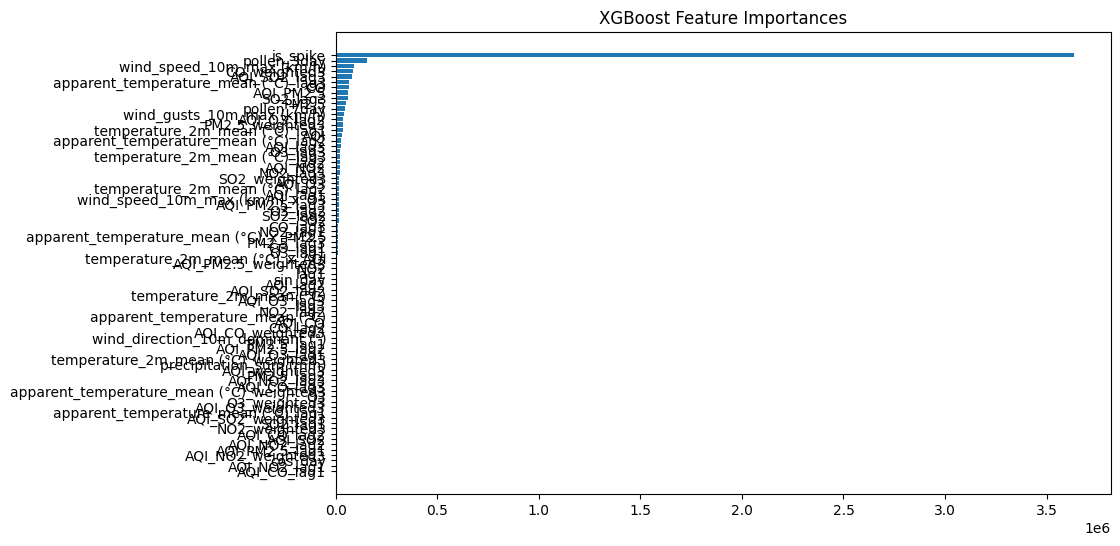

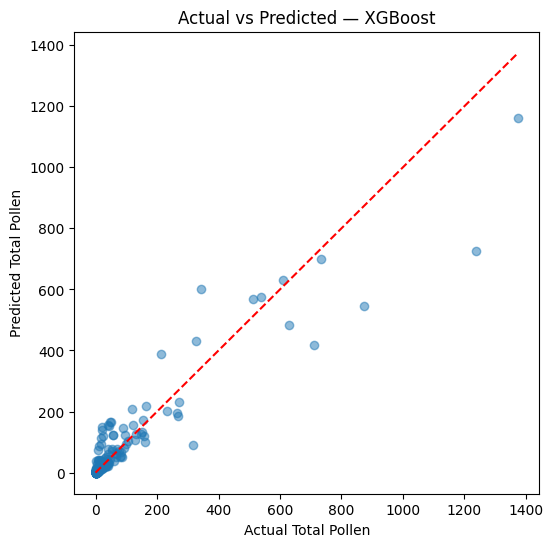

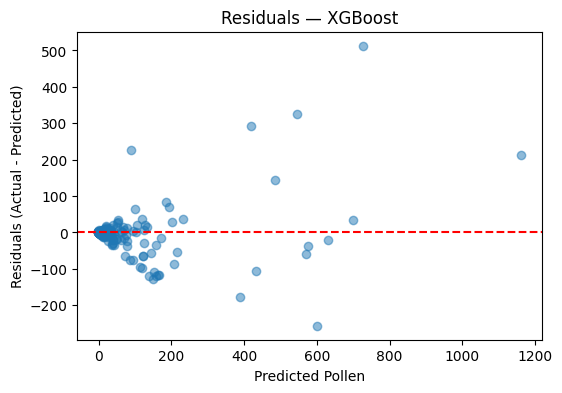

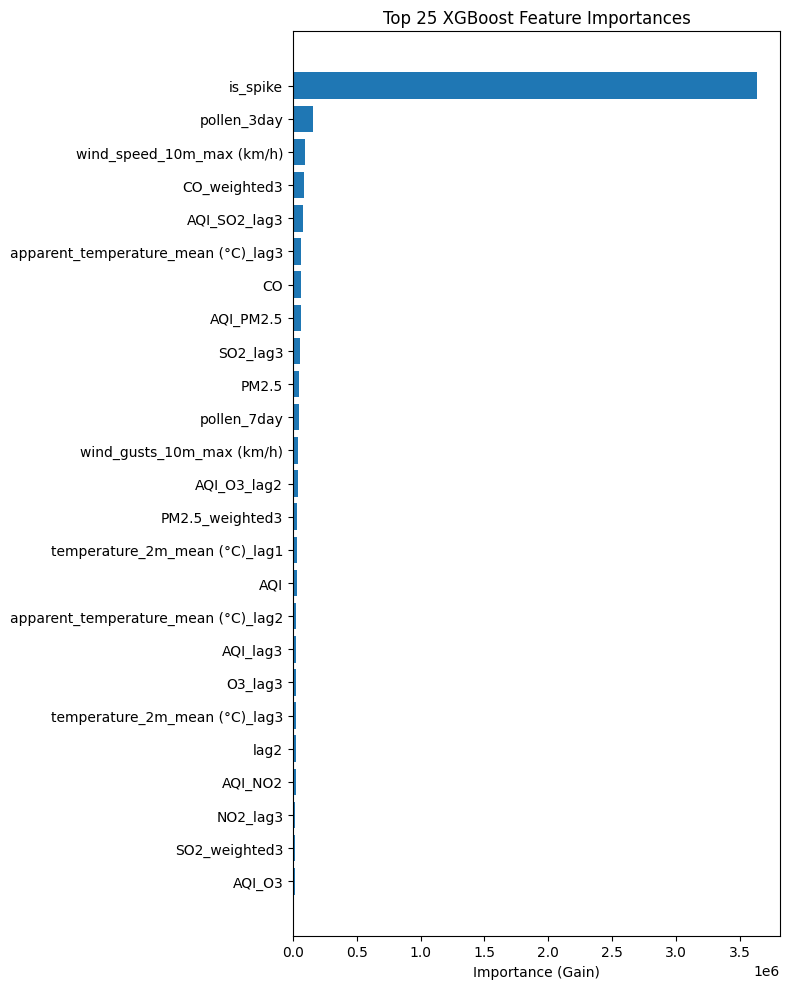

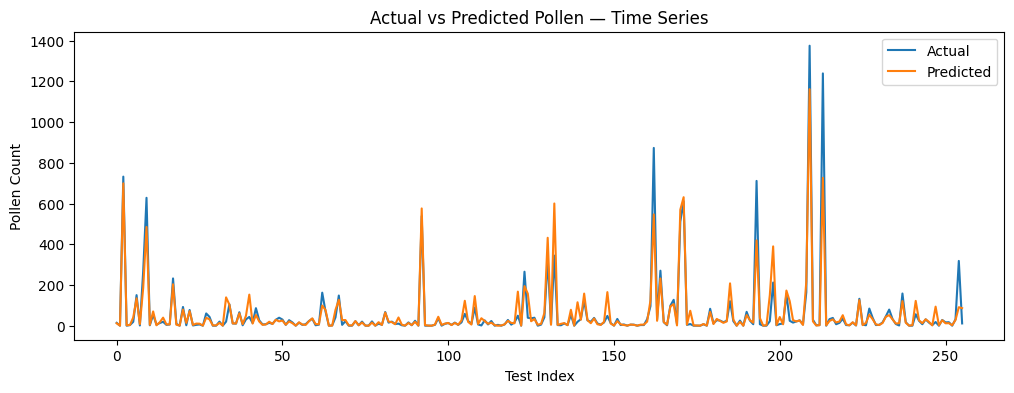

In [46]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --------------------------
# 1. Prepare dataframe
# --------------------------
df = merged.copy()

# Drop rows with missing numeric features
df = df.dropna(subset=numeric.columns)

# Create base pollen lags + rolling
df["day_of_year"] = df["Date"].dt.dayofyear
df["lag1"] = df["Total_Pollen"].shift(1)
df["lag2"] = df["Total_Pollen"].shift(2)
df["lag3"] = df["Total_Pollen"].shift(3)
df["pollen_3day"] = df["Total_Pollen"].rolling(3).mean()
df["pollen_7day"] = df["Total_Pollen"].rolling(7).mean()

# Spike indicator: pollen surge
threshold = df["Total_Pollen"].mean() + df["Total_Pollen"].std()
df["is_spike"] = (df["Total_Pollen"] > threshold).astype(int)

# Drop NA caused by shifting
df = df.dropna(subset=["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"])

# --------------------------
# 2. Seasonal sin/cos
# --------------------------
df["sin_day"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["cos_day"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

# --------------------------
# 3. Weighted rolling features (3-day)
# --------------------------
weights = np.array([0.1, 0.3, 0.6])  # older → newer

rolling_cols = [
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI'
]

for col in rolling_cols:
    df[f'{col}_weighted3'] = (
        df[col].shift(2).bfill() * weights[0] +
        df[col].shift(1).bfill() * weights[1] +
        df[col] * weights[2]
    )

# --------------------------
# 4. Lag features for pollutants (t-1, t-2, t-3)
# --------------------------
for col in rolling_cols:
    for lag in range(1, 4):
        df[f"{col}_lag{lag}"] = df[col].shift(lag).bfill()

# --------------------------
# 5. Interaction features
# --------------------------
interaction_pairs = [
    ('temperature_2m_mean (°C)', 'AQI'),
    ('apparent_temperature_mean (°C)', 'PM2.5'),
    ('wind_speed_10m_max (km/h)', 'O3'),
]

for col1, col2 in interaction_pairs:
    df[f'{col1}_x_{col2}'] = df[col1] * df[col2]

# --------------------------
# 6. Define features
# --------------------------
target = "Total_Pollen"

remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"]
base_features = [c for c in numeric.columns if c not in remove_cols]

extra_features = [
    "lag1", "lag2", "lag3",
    "pollen_3day", "pollen_7day",
    "is_spike",
    "sin_day", "cos_day"
]

weighted_features = [f"{col}_weighted3" for col in rolling_cols]
lag_features = [f"{col}_lag{lag}" for col in rolling_cols for lag in range(1, 4)]
interaction_features = [f"{a}_x_{b}" for a, b in interaction_pairs]

features = (
    base_features +
    extra_features +
    weighted_features +
    lag_features +
    interaction_features
)

X = df[features]
y = df[target]

# --------------------------
# 7. Train/test split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --------------------------
# 8. Convert to DMatrix
# --------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# --------------------------
# 9. XGBoost parameters
# --------------------------
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'seed': 42
}

# --------------------------
# 10. Train with early stopping
# --------------------------
evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1200,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

# --------------------------
# 11. Predictions
# --------------------------
y_pred = xgb_model.predict(dtest)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# --------------------------
# 12. Feature importance
# --------------------------
importance = xgb_model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.show()

# --------------------------
# 13. Visualization
# --------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Total Pollen")
plt.ylabel("Predicted Total Pollen")
plt.title("Actual vs Predicted — XGBoost")
plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals — XGBoost")
plt.show()

top_k = 25
top_feats = importance_df.head(top_k).sort_values("importance")

plt.figure(figsize=(8,10))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.xlabel("Importance (Gain)")
plt.title(f"Top {top_k} XGBoost Feature Importances")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted Pollen — Time Series")
plt.xlabel("Test Index")
plt.ylabel("Pollen Count")
plt.legend()
plt.show()




# With 2023 Data

Train size: (1910, 81)
Test size: (150, 81)
[0]	train-rmse:260.22836	eval-rmse:242.53052
[50]	train-rmse:46.45169	eval-rmse:115.18940
[100]	train-rmse:17.52704	eval-rmse:110.56347
[124]	train-rmse:12.73378	eval-rmse:110.60933
MAE: 36.076808385849
RMSE: 110.60933354103734
R²: 0.8081548146546467
                           feature    importance
23                        is_spike  1.020638e+07
21                     pollen_3day  3.856907e+05
63                     AQI_O3_lag1  2.166941e+05
51                         CO_lag1  1.874817e+05
78  wind_speed_10m_max (km/h)_x_O3  1.240351e+05
..                             ...           ...
72                    AQI_SO2_lag2  7.594047e+03
17        num_pollutants_available  4.868886e+03
68                     AQI_CO_lag3  3.852661e+03
66                     AQI_CO_lag1  7.969290e+02
13                          AQI_CO  6.195419e+02

[79 rows x 2 columns]


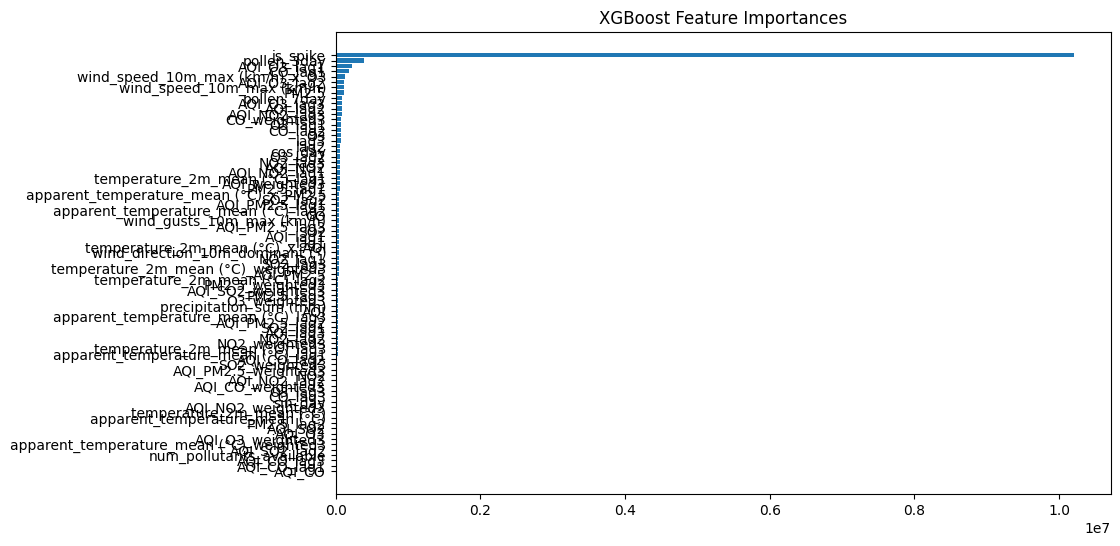

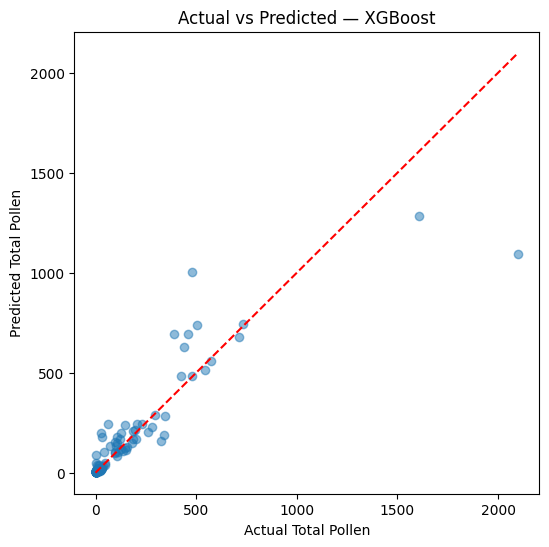

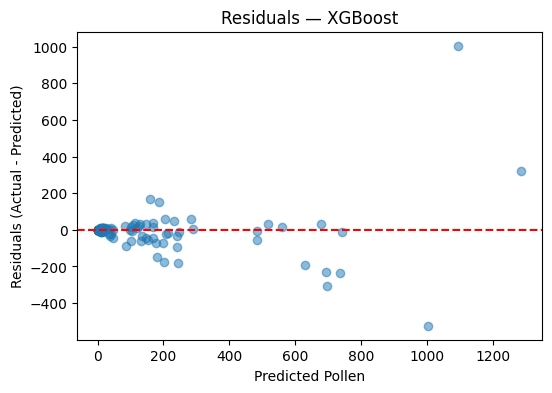

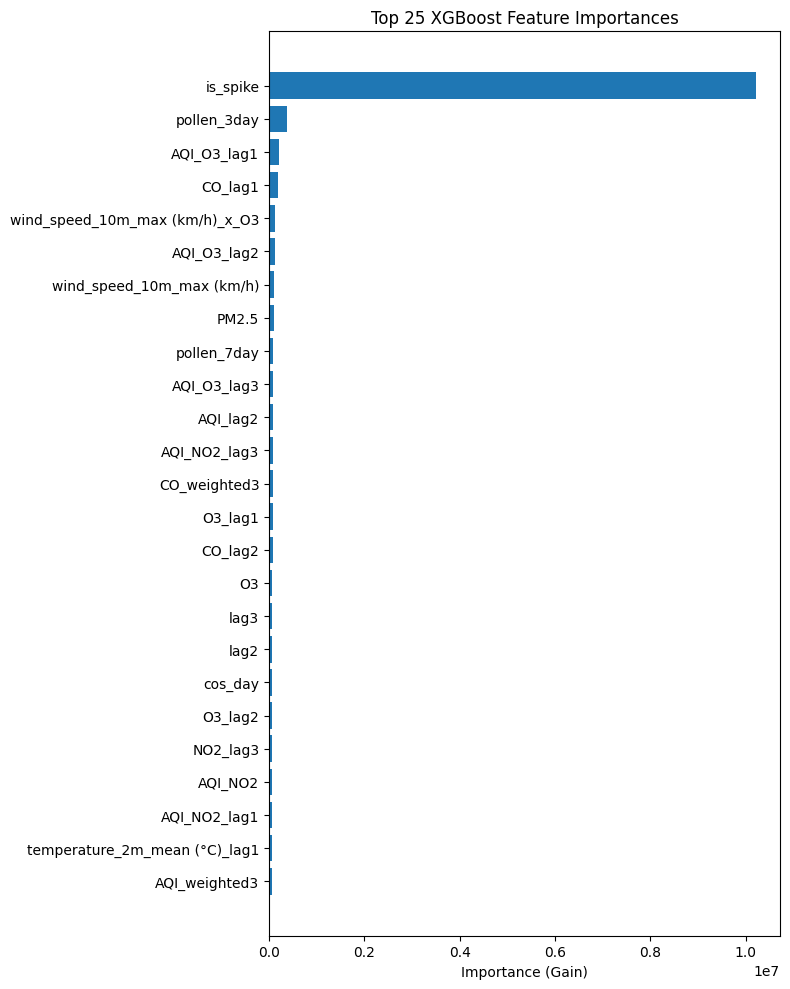

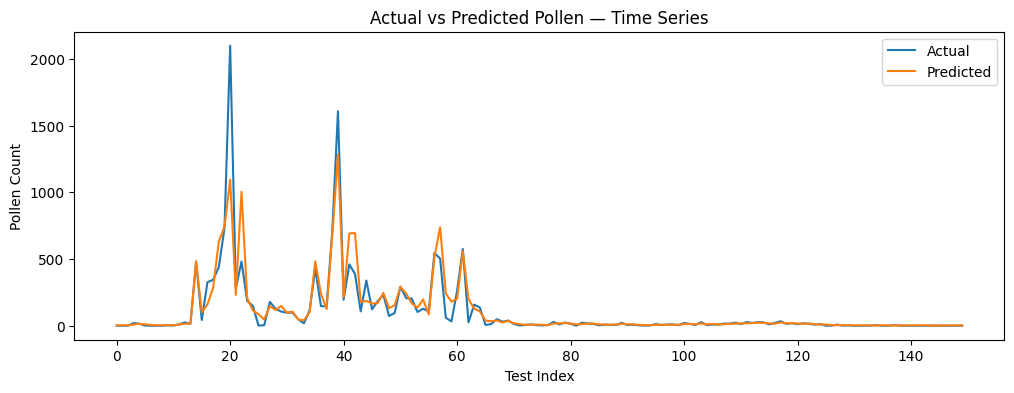

In [53]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# --------------------------
# 1. Prepare dataframe
# --------------------------
df = merged.copy()

# Ensure numeric columns
for col in numeric.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[numeric.columns] = df[numeric.columns].fillna(0)

# Base lags and rolling features
df["day_of_year"] = df["Date"].dt.dayofyear
df["lag1"] = df["Total_Pollen"].shift(1)
df["lag2"] = df["Total_Pollen"].shift(2)
df["lag3"] = df["Total_Pollen"].shift(3)
df["pollen_3day"] = df["Total_Pollen"].rolling(3).mean()
df["pollen_7day"] = df["Total_Pollen"].rolling(7).mean()

# Spike indicator
threshold = df["Total_Pollen"].mean() + df["Total_Pollen"].std()
df["is_spike"] = (df["Total_Pollen"] > threshold).astype(int)

df = df.dropna(subset=["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day"])

# Seasonal sin/cos
df["sin_day"] = np.sin(2 * np.pi * df["day_of_year"] / 365)
df["cos_day"] = np.cos(2 * np.pi * df["day_of_year"] / 365)

# Weighted rolling (3-day) for weather/pollutants
weights = np.array([0.1, 0.3, 0.6])
rolling_cols = [
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI'
]

for col in rolling_cols:
    df[f'{col}_weighted3'] = (
        df[col].shift(2).bfill() * weights[0] +
        df[col].shift(1).bfill() * weights[1] +
        df[col] * weights[2]
    )

# Lag features for pollutants
for col in rolling_cols:
    for lag in range(1, 4):
        df[f"{col}_lag{lag}"] = df[col].shift(lag).bfill()

# Interaction features
interaction_pairs = [
    ('temperature_2m_mean (°C)', 'AQI'),
    ('apparent_temperature_mean (°C)', 'PM2.5'),
    ('wind_speed_10m_max (km/h)', 'O3'),
]
for col1, col2 in interaction_pairs:
    df[f'{col1}_x_{col2}'] = df[col1] * df[col2]

# --------------------------
# 2. Define features
# --------------------------
target = "Total_Pollen"
remove_cols = ["Tree", "Grass", "Weed", "Ragweed", "Total_Pollen"]
base_features = [c for c in numeric.columns if c not in remove_cols]

extra_features = ["lag1", "lag2", "lag3", "pollen_3day", "pollen_7day",
                  "is_spike", "sin_day", "cos_day"]
weighted_features = [f"{col}_weighted3" for col in rolling_cols]
lag_features = [f"{col}_lag{lag}" for col in rolling_cols for lag in range(1, 4)]
interaction_features = [f"{a}_x_{b}" for a, b in interaction_pairs]

features = base_features + extra_features + weighted_features + lag_features + interaction_features

X = df[features]
y = df[target]

# --------------------------
# 3. Train/test split by year
# --------------------------
df['Year'] = df['Date'].dt.year
train_idx = df[df['Year'] < 2023].index
test_idx = df[df['Year'] == 2023].index

X_train = X.loc[train_idx]
y_train = y.loc[train_idx]

X_test = X.loc[test_idx]
y_test = y.loc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# --------------------------
# 4. Convert to DMatrix
# --------------------------
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# --------------------------
# 5. XGBoost parameters
# --------------------------
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'eval_metric': 'rmse',
    'seed': 42
}

# --------------------------
# 6. Train with early stopping
# --------------------------
evals = [(dtrain, 'train'), (dtest, 'eval')]
xgb_model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1200,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

# --------------------------
# 7. Predictions
# --------------------------
y_pred = xgb_model.predict(dtest)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

# --------------------------
# 8. Feature importance
# --------------------------
importance = xgb_model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importances")
plt.show()

# --------------------------
# 9. Visualizations
# --------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Total Pollen")
plt.ylabel("Predicted Total Pollen")
plt.title("Actual vs Predicted — XGBoost")
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals — XGBoost")
plt.show()

top_k = 25
top_feats = importance_df.head(top_k).sort_values("importance")
plt.figure(figsize=(8,10))
plt.barh(top_feats["feature"], top_feats["importance"])
plt.xlabel("Importance (Gain)")
plt.title(f"Top {top_k} XGBoost Feature Importances")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("Actual vs Predicted Pollen — Time Series")
plt.xlabel("Test Index")
plt.ylabel("Pollen Count")
plt.legend()
plt.show()


# 6. Trying Random Forest without Pollen Data


Training Metrics:
MAE: 42.619759865560134
RMSE: 123.94238789446794
R²: 0.7664215440356161

Test Metrics:
MAE: 45.03334031819841
RMSE: 83.14103002151019
R²: 0.7360784517749721

Keeping 21 features out of 75

Training Metrics (Trimmed):
MAE: 38.58011416529012
RMSE: 119.2988324708247
R²: 0.7835959162994246

Test Metrics (Trimmed):
MAE: 35.846429711864076
RMSE: 75.60548221507743
R²: 0.7817518232069091
Feature Importances (Trimmed 22-Feature Model):
                                     feature  importance
0                                   is_spike    0.340108
1                                    sin_day    0.111715
2        apparent_temperature_mean (°C)_lag3    0.042917
7                                    cos_day    0.041271
14                 wind_speed_10m_max (km/h)    0.040072
3              temperature_2m_mean (°C)_lag3    0.037228
17                                  SO2_lag3    0.035206
5   apparent_temperature_mean (°C)_weighted3    0.034408
4        apparent_temperature_mean (°C

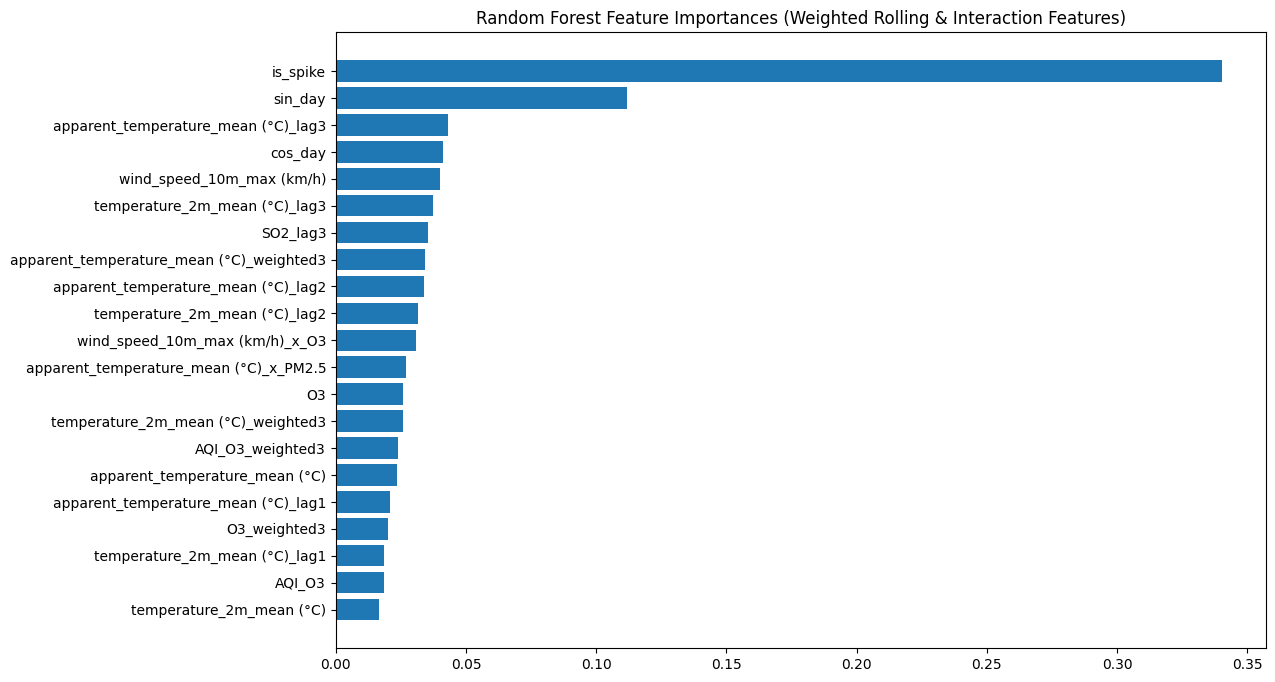

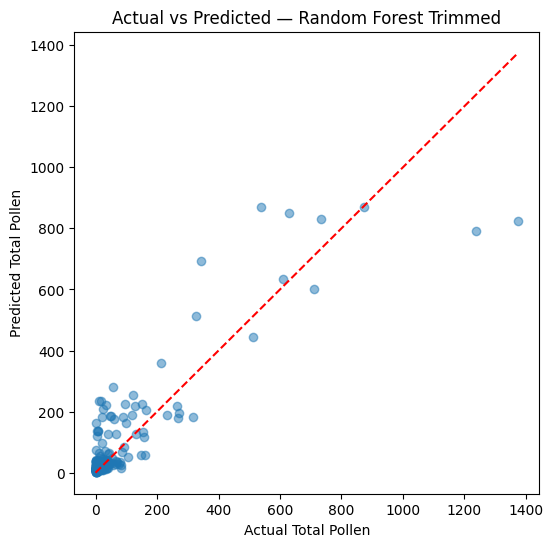

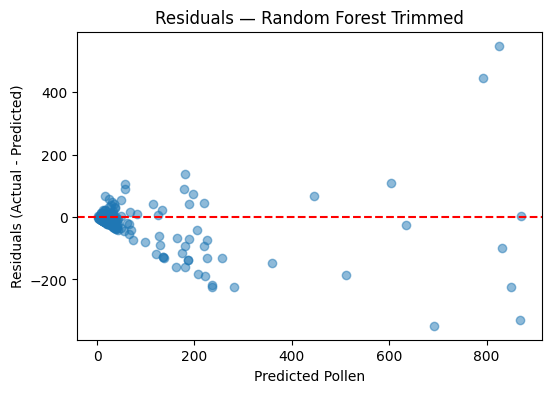

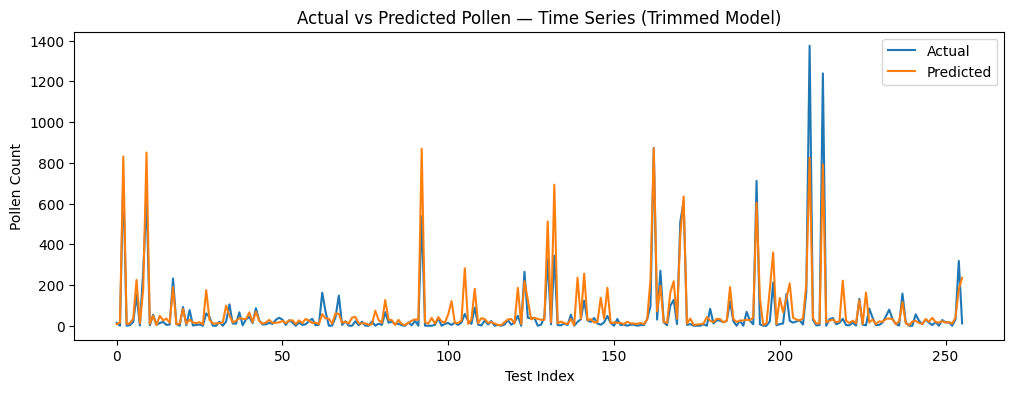

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. Select base features
# ------------------------------
features = [
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'precipitation_sum (mm)',
    'wind_gusts_10m_max (km/h)', 'wind_speed_10m_max (km/h)', 'wind_direction_10m_dominant (°)',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI',
    'day_of_year', 'is_spike'
]

X = df[features].copy()
y = df['Total_Pollen']

# ------------------------------
# 2. Add seasonal sin/cos features
# ------------------------------
X['sin_day'] = np.sin(2 * np.pi * X['day_of_year'] / 365)
X['cos_day'] = np.cos(2 * np.pi * X['day_of_year'] / 365)
X = X.drop(columns=['day_of_year'])

# ------------------------------
# 3. Create weighted 3-day rolling averages
# ------------------------------
weights = np.array([0.1, 0.3, 0.6])  # weights: older → newer
rolling_cols = [
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI'
]

for col in rolling_cols:
    X[f'{col}_weighted3'] = (
        X[col].shift(2).bfill() * weights[0] +
        X[col].shift(1).bfill() * weights[1] +
        X[col] * weights[2]
    )

# ------------------------------
# 4. Create lag features (t-1, t-2, t-3)
# ------------------------------
for col in rolling_cols:
    for lag in range(1, 4):
        X[f'{col}_lag{lag}'] = X[col].shift(lag).bfill()

# ------------------------------
# 5. Create interaction features
# ------------------------------
interaction_pairs = [
    ('temperature_2m_mean (°C)', 'AQI'),
    ('apparent_temperature_mean (°C)', 'PM2.5'),
    ('wind_speed_10m_max (km/h)', 'O3'),
]

for col1, col2 in interaction_pairs:
    X[f'{col1}_x_{col2}'] = X[col1] * X[col2]

# ------------------------------
# 6. Train-test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ------------------------------
# 7. Sample weights for spikes
# ------------------------------
sample_weights = np.where(X_train['is_spike'] == 1, 1.75, 1)

# ------------------------------
# 8. Train initial Random Forest
# ------------------------------
rf = RandomForestRegressor(
    n_estimators=1200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train, sample_weight=sample_weights)

# ------------------------------
# 9. Make initial predictions
# ------------------------------
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# ------------------------------
# 10. Evaluate initial model
# ------------------------------
print("Training Metrics:")
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R²:", r2_score(y_train, y_train_pred))

print("\nTest Metrics:")
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("R²:", r2_score(y_test, y_test_pred))

# ------------------------------
# 11. Feature importance (initial)
# ------------------------------
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# ------------------------------
# 12. Trim features by importance threshold
# ------------------------------
importance_threshold = 0.012
important_features = importance[importance['importance'] > importance_threshold]['feature'].tolist()
print(f"\nKeeping {len(important_features)} features out of {len(X_train.columns)}")

# ------------------------------
# 13. Subset data for trimmed model
# ------------------------------
X_train_trim = X_train[important_features]
X_test_trim = X_test[important_features]

# ------------------------------
# 14. Re-train Random Forest on trimmed features
# ------------------------------
rf_trim = RandomForestRegressor(
    n_estimators=1200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_trim.fit(X_train_trim, y_train, sample_weight=sample_weights)

# ------------------------------
# 15. Predictions (trimmed model)
# ------------------------------
y_train_pred_trim = rf_trim.predict(X_train_trim)
y_test_pred_trim = rf_trim.predict(X_test_trim)

# ------------------------------
# 16. Evaluate trimmed model
# ------------------------------
print("\nTraining Metrics (Trimmed):")
print("MAE:", mean_absolute_error(y_train, y_train_pred_trim))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_trim)))
print("R²:", r2_score(y_train, y_train_pred_trim))

print("\nTest Metrics (Trimmed):")
print("MAE:", mean_absolute_error(y_test, y_test_pred_trim))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_trim)))
print("R²:", r2_score(y_test, y_test_pred_trim))

# ------------------------------
# 17. Feature importance (trimmed)
# ------------------------------
importance_trim = pd.DataFrame({
    'feature': X_train_trim.columns,
    'importance': rf_trim.feature_importances_
}).sort_values(by='importance', ascending=False)

print("Feature Importances (Trimmed 22-Feature Model):")
print(importance_trim)

plt.figure(figsize=(12,8))
plt.barh(importance_trim['feature'], importance_trim['importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances (Weighted Rolling & Interaction Features)')
plt.show()


# ------------------------------
# 17. Visualization
# ------------------------------

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_trim, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Actual Total Pollen")
plt.ylabel("Predicted Total Pollen")
plt.title("Actual vs Predicted — Random Forest Trimmed")
plt.show()

residuals = y_test - y_test_pred_trim

plt.figure(figsize=(6,4))
plt.scatter(y_test_pred_trim, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals — Random Forest Trimmed")
plt.show()


plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_test_pred_trim, label="Predicted")
plt.title("Actual vs Predicted Pollen — Time Series (Trimmed Model)")
plt.xlabel("Test Index")
plt.ylabel("Pollen Count")
plt.legend()
plt.show()






# With 2023 Data

Train size: (1910, 75)
Test size: (150, 75)
Training Metrics:
MAE: 44.9989648238888
RMSE: 110.5313687745844
R²: 0.8346360031303747

Test Metrics:
MAE: 80.15171612432722
RMSE: 171.80012440280188
R²: 0.5371776734009828

Keeping 17 features out of 75

Training Metrics (Trimmed):
MAE: 40.644464164294995
RMSE: 107.93021732774169
R²: 0.8423274950061947

Test Metrics (Trimmed):
MAE: 63.18885186319633
RMSE: 163.40807523158924
R²: 0.5812889885930732


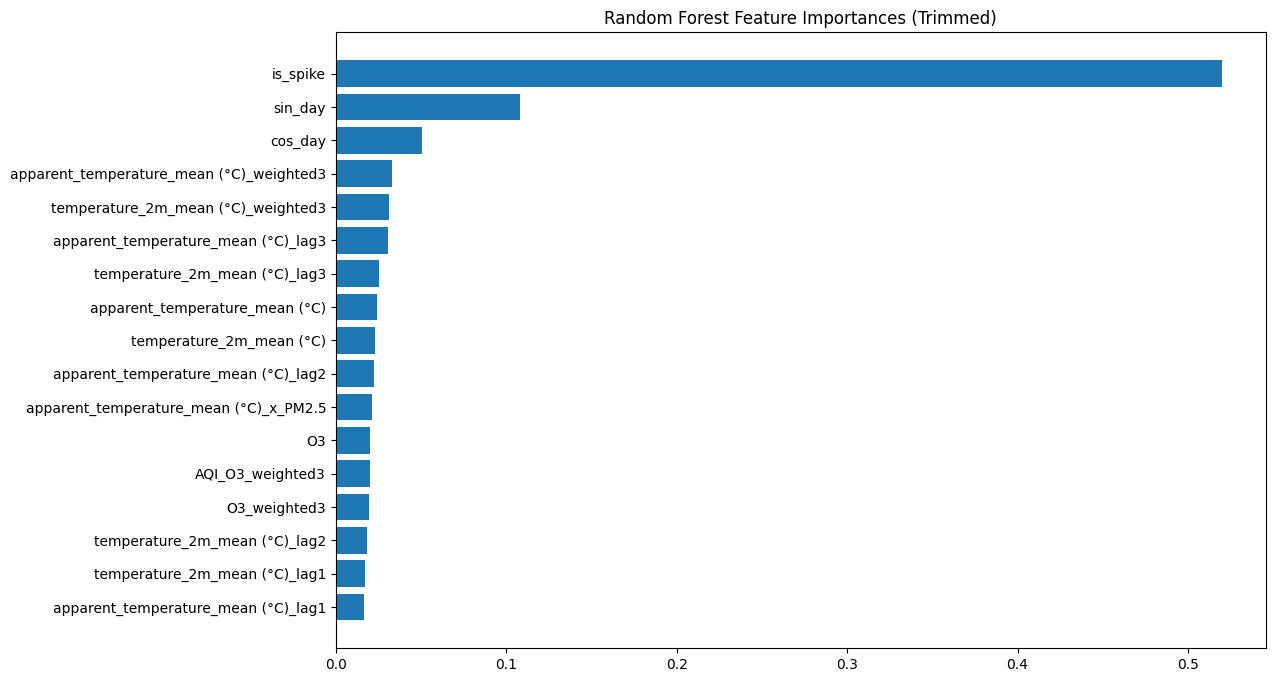

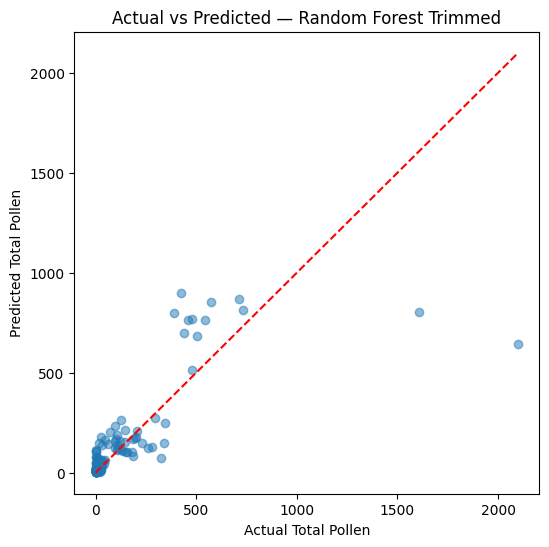

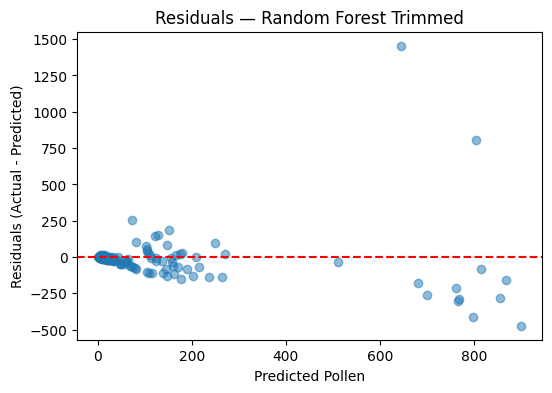

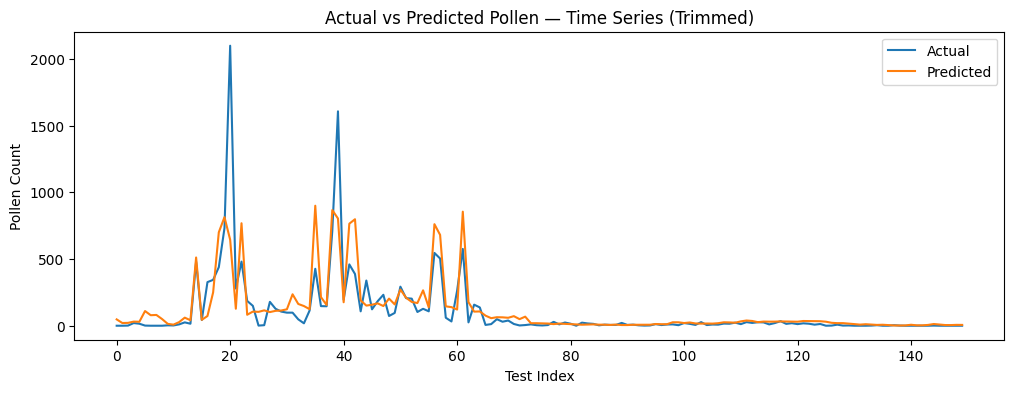

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# 1. Base features
# ------------------------------
features = [
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'precipitation_sum (mm)',
    'wind_gusts_10m_max (km/h)', 'wind_speed_10m_max (km/h)', 'wind_direction_10m_dominant (°)',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI',
    'day_of_year', 'is_spike'
]

X = df[features].copy()
y = df['Total_Pollen']

# ------------------------------
# 2. Seasonal sin/cos
# ------------------------------
X['sin_day'] = np.sin(2 * np.pi * X['day_of_year'] / 365)
X['cos_day'] = np.cos(2 * np.pi * X['day_of_year'] / 365)
X = X.drop(columns=['day_of_year'])

# ------------------------------
# 3. Weighted 3-day rolling averages
# ------------------------------
weights = np.array([0.1, 0.3, 0.6])
rolling_cols = [
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI'
]

for col in rolling_cols:
    X[f'{col}_weighted3'] = (
        X[col].shift(2).bfill() * weights[0] +
        X[col].shift(1).bfill() * weights[1] +
        X[col] * weights[2]
    )

# ------------------------------
# 4. Lag features t-1, t-2, t-3
# ------------------------------
for col in rolling_cols:
    for lag in range(1, 4):
        X[f'{col}_lag{lag}'] = X[col].shift(lag).bfill()

# ------------------------------
# 5. Interaction features
# ------------------------------
interaction_pairs = [
    ('temperature_2m_mean (°C)', 'AQI'),
    ('apparent_temperature_mean (°C)', 'PM2.5'),
    ('wind_speed_10m_max (km/h)', 'O3'),
]

for col1, col2 in interaction_pairs:
    X[f'{col1}_x_{col2}'] = X[col1] * X[col2]

# ------------------------------
# 6. Train/test split by year
# ------------------------------
df['Year'] = df['Date'].dt.year
train_idx = df[df['Year'] < 2023].index
test_idx = df[df['Year'] == 2023].index

X_train = X.loc[train_idx]
y_train = y.loc[train_idx]
X_test = X.loc[test_idx]
y_test = y.loc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# ------------------------------
# 7. Sample weights for spikes
# ------------------------------
sample_weights = np.where(X_train['is_spike'] == 1, 1.75, 1)

# ------------------------------
# 8. Train initial Random Forest
# ------------------------------
rf = RandomForestRegressor(
    n_estimators=1200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train, sample_weight=sample_weights)

# ------------------------------
# 9. Predictions & evaluation
# ------------------------------
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

print("Training Metrics:")
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R²:", r2_score(y_train, y_train_pred))

print("\nTest Metrics:")
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("R²:", r2_score(y_test, y_test_pred))

# ------------------------------
# 10. Feature importance (initial)
# ------------------------------
importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# ------------------------------
# 11. Trim features by importance
# ------------------------------
importance_threshold = 0.012
important_features = importance[importance['importance'] > importance_threshold]['feature'].tolist()
print(f"\nKeeping {len(important_features)} features out of {len(X_train.columns)}")

X_train_trim = X_train[important_features]
X_test_trim = X_test[important_features]

# ------------------------------
# 12. Retrain Random Forest (trimmed)
# ------------------------------
rf_trim = RandomForestRegressor(
    n_estimators=1200,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
rf_trim.fit(X_train_trim, y_train, sample_weight=sample_weights)

y_train_pred_trim = rf_trim.predict(X_train_trim)
y_test_pred_trim = rf_trim.predict(X_test_trim)

print("\nTraining Metrics (Trimmed):")
print("MAE:", mean_absolute_error(y_train, y_train_pred_trim))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred_trim)))
print("R²:", r2_score(y_train, y_train_pred_trim))

print("\nTest Metrics (Trimmed):")
print("MAE:", mean_absolute_error(y_test, y_test_pred_trim))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_trim)))
print("R²:", r2_score(y_test, y_test_pred_trim))

# ------------------------------
# 13. Feature importance & plots
# ------------------------------
importance_trim = pd.DataFrame({
    'feature': X_train_trim.columns,
    'importance': rf_trim.feature_importances_
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,8))
plt.barh(importance_trim['feature'], importance_trim['importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importances (Trimmed)')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred_trim, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Total Pollen")
plt.ylabel("Predicted Total Pollen")
plt.title("Actual vs Predicted — Random Forest Trimmed")
plt.show()

residuals = y_test - y_test_pred_trim
plt.figure(figsize=(6,4))
plt.scatter(y_test_pred_trim, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Pollen")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals — Random Forest Trimmed")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(y_test.values, label="Actual")
plt.plot(y_test_pred_trim, label="Predicted")
plt.title("Actual vs Predicted Pollen — Time Series (Trimmed)")
plt.xlabel("Test Index")
plt.ylabel("Pollen Count")
plt.legend()
plt.show()


# 7. Ensemble Attempt (Fruitless)

In [31]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb

# ==============================================================
# 1. FUNCTION: Run Manual Stacking Ensemble
# ==============================================================
def run_manual_stacking_full(
    X, y,
    spike_weight_col=None,
    random_state=42,
    trim_features=True,
    trim_thresh=0.005
):
    """
    Train a stacking ensemble with optional spike weighting and feature trimming.

    Parameters:
    - X: DataFrame of features
    - y: Series/array of target
    - spike_weight_col: column in X marking spikes (optional)
    - random_state: int for reproducibility
    - trim_features: whether to trim features based on importance
    - trim_thresh: threshold for feature importance trimming
    """

    # ----------------------------------------------------------
    # 1a. Train-test split
    # ----------------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    # ----------------------------------------------------------
    # 1b. Spike weighting (optional)
    # ----------------------------------------------------------
    if spike_weight_col is not None:
        sample_weights = np.where(X_train[spike_weight_col] == 1, 1.75, 1)
    else:
        sample_weights = None

    # ----------------------------------------------------------
    # 1c. Feature trimming (optional)
    # ----------------------------------------------------------
    if trim_features:
        # Fit base RF to compute feature importances
        base_rf = RandomForestRegressor(n_estimators=200, random_state=random_state)
        base_rf.fit(X_train, y_train, sample_weight=sample_weights)

        # Select features above threshold
        selector = SelectFromModel(base_rf, threshold=trim_thresh, prefit=True)
        selected_cols = X_train.columns[selector.get_support()]

        # Keep only selected columns
        X_train = pd.DataFrame(selector.transform(X_train), columns=selected_cols, index=X_train.index)
        X_test = pd.DataFrame(selector.transform(X_test), columns=selected_cols, index=X_test.index)
        print(f"Trimmed features: {X_train.shape[1]} out of {X.shape[1]} retained")

    # ----------------------------------------------------------
    # 2. Define base learners
    # ----------------------------------------------------------
    rf = RandomForestRegressor(n_estimators=200, random_state=random_state)
    xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=random_state)
    lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=random_state)

    # ----------------------------------------------------------
    # 3. Define stacking ensemble
    # ----------------------------------------------------------
    stack = StackingRegressor(
        estimators=[('rf', rf), ('xgb', xgb_model), ('lgb', lgb_model)],
        final_estimator=RandomForestRegressor(n_estimators=200, random_state=random_state),
        passthrough=True,
        n_jobs=-1
    )

    # ----------------------------------------------------------
    # 4. Fit ensemble
    # Note: sample_weight not passed to final estimator
    # ----------------------------------------------------------
    stack.fit(X_train, y_train)

    # ----------------------------------------------------------
    # 5. Predictions
    # ----------------------------------------------------------
    y_train_pred = stack.predict(X_train)
    y_test_pred = stack.predict(X_test)

    # ----------------------------------------------------------
    # 6. Metrics
    # ----------------------------------------------------------
    print("\nTraining Metrics:")
    print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
    print(f"R²: {r2_score(y_train, y_train_pred):.4f}")

    print("\nTest Metrics:")
    print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")
    print(f"R²: {r2_score(y_test, y_test_pred):.4f}")

    # ----------------------------------------------------------
    # Return trained model and data splits
    # ----------------------------------------------------------
    return stack, X_train, X_test, y_train, y_test


# ==============================================================
# 2. PREPARE FEATURE SETS
# ==============================================================

# --- Features WITH pollen ---
features_with = [
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'precipitation_sum (mm)',
    'wind_gusts_10m_max (km/h)', 'wind_speed_10m_max (km/h)', 'wind_direction_10m_dominant (°)',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI',
    'day_of_year', 'is_spike',
    'pollen_3day', 'lag1', 'lag2'
]

X_with = df[features_with].copy()
y_with = df['Total_Pollen']

# --- Features WITHOUT pollen ---
features_without = [
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)', 'precipitation_sum (mm)',
    'wind_gusts_10m_max (km/h)', 'wind_speed_10m_max (km/h)', 'wind_direction_10m_dominant (°)',
    'PM2.5', 'O3', 'CO', 'NO2', 'SO2',
    'AQI_PM2.5', 'AQI_O3', 'AQI_CO', 'AQI_NO2', 'AQI_SO2', 'AQI',
    'day_of_year', 'is_spike'
]

X_without = df[features_without].copy()
y_without = df['Total_Pollen']

# ==============================================================
# 3. RUN ENSEMBLE MODELS
# ==============================================================

# --- Ensemble WITH pollen ---
print("\n=== Ensemble WITH pollen ===")
ensemble_with, X_train_with, X_test_with, y_train_with, y_test_with = run_manual_stacking_full(
    X_with, y_with, spike_weight_col='is_spike'
)

# --- Ensemble WITHOUT pollen ---
print("\n=== Ensemble WITHOUT pollen ===")
ensemble_without, X_train_without, X_test_without, y_train_without, y_test_without = run_manual_stacking_full(
    X_without, y_without, spike_weight_col='is_spike'
)



=== Ensemble WITH pollen ===


/Users/annalaprade/boston-aqi-prediction/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/annalaprade/boston-aqi-prediction/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Trimmed features: 10 out of 22 retained
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1789
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 10
[LightGBM] [Info] Start training from score 88.673611
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_col_wise=true` 

/Users/annalaprade/boston-aqi-prediction/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/annalaprade/boston-aqi-prediction/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Trimmed features: 18 out of 19 retained
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2711
[LightGBM] [Info] Number of data points in the train set: 1022, number of used features: 18
[LightGBM] [Info] Start training from score 88.673611
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` 